# An example of using EASYMORE with source netCDF files in irregualr shape 
## Remapping of SCDNA to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [1]:
# download SCDNA data and convert it to xarray-based format

import xarray as xr
import urllib.request
import numpy as np
import pandas as pd
import os
from datetime import datetime
import time

pwd = '/Users/shg096/Desktop/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'
fname = 'SCDNA_v1.1.nc'

def download_process_SCDNA(pwd, filename):
    
    if not os.path.isdir(pwd):
        os.mkdir(pwd)
    
    # remove existing file is exists
    outfile = pwd+filename
    if os.path.isfile(outfile):
        print('It seems the file exists; perhaps perviously downloaded; will skip downloading')
    else:
        # download the file
        print('Downloading SCDNA; this may take a while ...')
        print('Downloading starts at: ', datetime.now())
        url = 'http://zenodo.org/record/3953310/files/SCDNA_v1.1.nc4?download=1'
        urllib.request.urlretrieve(url, outfile)
        print('Downloading ends at: ', datetime.now())
    
    if not os.path.isdir(pwd+'/prcp/'):
        os.mkdir (pwd+'/prcp/')
    if not os.path.isdir(pwd+'/tmin/'):
        os.mkdir (pwd+'/tmin/')
    if not os.path.isdir(pwd+'/tmax/'):
        os.mkdir (pwd+'/tmax/')
    
    print('Formatting SCDNA ...')
    print('Formatting starts at: ', datetime.now())
    ds         = xr.open_dataset(outfile)
    ds         = ds.load()
    nstn       = ds.LLE.shape[1] # number of stations
    ds         = ds.rename({'nstn':'stn','nday':'time'}) # renaming
    ds['stn']  = np.arange(nstn) + 1 # ID of stations from 1 to the number of stations
    ds['time'] = pd.date_range(start=str(ds.date[0].values),\
                               end=str(ds.date[-1].values),freq='1D') # time
    ds         = ds.set_coords('stn') # set stn as coordinate
    ds         = ds.set_coords('time') # set time as coordinate
    ds['lat']  = ds.LLE[0, :] # pass lat values to a new variable
    ds['lon']  = ds.LLE[1, :] # pass lon values to a new variable
    ds['elev'] = ds.LLE[2, :] # pass elevation values to a new variable
    
    # get the sart and end year
    start_year = int(str(ds.date[0].values)[0:4])
    end_year   = int(str(ds.date[-1].values)[0:4])
    years      = list (np.arange(start_year, end_year+1))
    
    # drop the varibales
    ds = ds.drop(['ID','LLE', 'date', 'sflag', 'prcp_flag', 'prcp_kge',\
                  'tmin_flag', 'tmin_kge', 'tmax_flag', 'tmax_kge'])
    
    # subset based on prec, tmin or tmax
    temp          = ds['prcp'].isel(time=0).values
    stnvalidprcp  = np.where(~np.isnan(temp))[0]
    print('Number of stations with precipitation data: ', len(stnvalidprcp))

    temp          = ds['tmin'].isel(time=0).values
    stnvalidtmin  = np.where(~np.isnan(temp))[0]
    print('Number of stations with minimum temprature data: ', len(stnvalidtmin))

    temp          = ds['tmax'].isel(time=0).values
    stnvalidtmax  = np.where(~np.isnan(temp))[0]
    print('Number of stations with maximum temprature data: ', len(stnvalidtmax))
    
    #
    print('Formatting ends at: ', datetime.now())
    
    #
    print('Slicing SCDNA and saving it in yearly files ...')
    print('Slicing starts at: ', datetime.now())
    
    for year in years:
        year_str = str(year)
        print(year_str)
        outfile = pwd+'/SCDNA_v1.1.'+year_str+'.nc'
        temp = ds.sel(time=slice(year_str,year_str)) # slice for time\        
        if os.path.isfile (outfile):
            os.remove(outfile)
        temp.to_netcdf(outfile)
        # print ('Yearly SCDNA file is saved for '+year_str+' at '+ outfile)
        
        # reload the file
        #temp = xr.open_dataset(outfile)

        # precipitation
        temp_prcp = temp.drop(['tmin', 'tmax'])
        temp_prcp = temp_prcp.isel(stn=stnvalidprcp)
        outfile_prcp = pwd+'/prcp/SCDNA_v1.1.prcp.'+year_str+'.nc'
        if os.path.isfile (outfile_prcp):
            os.remove(outfile_prcp)
        temp_prcp.to_netcdf(outfile_prcp)
        #print ('Yearly SCDNA precipitation file is saved for '+year_str+' at '+ outfile_prcp)

        # tmin
        temp_tmin = temp.drop(['prcp', 'tmax'])
        temp_tmin = temp_tmin.isel(stn=stnvalidtmin)
        outfile_tmin = pwd+'/tmin/SCDNA_v1.1.tmin.'+year_str+'.nc'
        if os.path.isfile (outfile_tmin):
            os.remove(outfile_tmin)
        temp_tmin.to_netcdf(outfile_tmin)
        #print ('Yearly SCDNA minimum temperature file is saved for '+year_str+' at '+ outfile_tmin)

        # tmax
        temp_tmax = temp.drop(['prcp', 'tmin'])
        temp_tmax = temp_tmax.isel(stn=stnvalidtmax)
        outfile_tmax = pwd+'/tmax/SCDNA_v1.1.tmax.'+year_str+'.nc'
        if os.path.isfile (outfile_tmax):
            os.remove(outfile_tmax)
        temp_tmax.to_netcdf(outfile_tmax)
        #print ('Yearly SCDNA maximum temperature file is saved for '+year_str+' at '+ outfile_tmax)
        
        # remove the file
        os.remove (outfile)
        
    print('Slicing ends at: ', datetime.now())
        
    
# call the function
download_process_SCDNA(pwd, fname)



It seems the file exists; perhaps perviously downloaded; will skip downloading
Formatting SCDNA ...
Formatting starts at:  2021-02-17 20:30:43.451890
Number of stations with precipitation data:  24615
Number of stations with minimum temprature data:  19604
Number of stations with maximum temprature data:  19611
Formatting ends at:  2021-02-17 20:31:48.688537
Slicing SCDNA and saving it in yearly files ...
Slicing starts at:  2021-02-17 20:31:48.688647
1979
1980
1981
Slicing ends at:  2021-02-17 20:34:02.302326


In [58]:
import xarray as xr
import numpy as np


ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA/SCDNA_v1.1.nc')

print(ds.dims)

print(np.array(ds['nstn'][:]))

AAA = np.array(ds['nstn'][:])

for i in AAA:
    
    print(i)
    
    array = np.array(ds['ID'][:,i])
    
    print(array)

    array = [str(s, encoding='UTF-8') for s in array]
    
    array = ''.join(array)
    
    print(array)
    

ll
print(A)

A = ''.join(A)

print(A)

ll
AA =[b''.join(r).decode() for r in A]

print(AA)
ll

[b''.join(r).decode() for r in A]

print(r)


Frozen({'nchar': 13, 'nstn': 27276, 'lle': 3, 'nday': 14610, 'nsf': 3})
[    0     1     2 ... 27273 27274 27275]
0
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'0' b'0' b'6' b'6']
ECCA001010066
1
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'0' b'9' b'6' b'0']
ECCA001010960
2
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'1' b'4' b'6' b'7']
ECCA001011467
3
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'1' b'4' b'F' b'6']
ECCA0010114F6
4
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'1' b'5' b'0' b'0']
ECCA001011500
5
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'1' b'8' b'1' b'0']
ECCA001011810
6
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'1' b'9' b'2' b'2']
ECCA001011922
7
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'2' b'0' b'1' b'0']
ECCA001012010
8
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'2' b'0' b'4' b'0']
ECCA001012040
9
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'2' b'0' b'5' b'5']
ECCA001012055
10
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'1' b'2' b'

[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'4' b'1' b'2' b'5']
ECCA001094125
214
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'4' b'1' b'2' b'7']
ECCA001094127
215
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'4' b'6' b'1' b'6']
ECCA001094616
216
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'4' b'9' b'4' b'8']
ECCA001094948
217
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'4' b'9' b'5' b'5']
ECCA001094955
218
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'5' b'0' b'1' b'5']
ECCA001095015
219
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'5' b'0' b'1' b'8']
ECCA001095018
220
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'5' b'2' b'B' b'9']
ECCA0010952B9
221
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'5' b'6' b'7' b'6']
ECCA001095676
222
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'6' b'4' b'5' b'3']
ECCA001096453
223
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'6' b'4' b'5' b'5']
ECCA001096455
224
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'0' b'9' b'6' b'4' b'5' b'8'

[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'4' b'E' b'M' b'D' b'M']
ECCA00114EMDM
394
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'4' b'Q' b'3' b'C' b'9']
ECCA00114Q3C9
395
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'0' b'6' b'9' b'0']
ECCA001150690
396
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'1' b'9' b'1' b'5']
ECCA001151915
397
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'2' b'1' b'0' b'9']
ECCA001152109
398
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'2' b'6' b'5' b'3']
ECCA001152653
399
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'2' b'6' b'7' b'0']
ECCA001152670
400
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'2' b'8' b'5' b'0']
ECCA001152850
401
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'2' b'8' b'9' b'9']
ECCA001152899
402
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'2' b'J' b'0' b'2']
ECCA001152J02
403
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'3' b'0' b'3' b'4']
ECCA001153034
404
[b'E' b'C' b'C' b'A' b'0' b'0' b'1' b'1' b'5' b'3' b'2' b'8' b'2'

[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'2' b'5' b'4' b'3']
ECCA002402543
610
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'2' b'5' b'9' b'2']
ECCA002402592
611
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'2' b'7' b'3' b'0']
ECCA002402730
612
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'3' b'0' b'5' b'3']
ECCA002403053
613
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'3' b'2' b'0' b'1']
ECCA002403201
614
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'3' b'4' b'5' b'0']
ECCA002403450
615
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'3' b'4' b'9' b'0']
ECCA002403490
616
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'3' b'5' b'0' b'5']
ECCA002403505
617
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'3' b'7' b'5' b'6']
ECCA002403756
618
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'3' b'8' b'5' b'4']
ECCA002403854
619
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'K' b'F' b'Q' b'J']
ECCA00240KFQJ
620
[b'E' b'C' b'C' b'A' b'0' b'0' b'2' b'5' b'0' b'0' b'4' b'4' b'0'

[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'0' b'6' b'8' b'0']
ECCA003030680
816
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'0' b'7' b'2' b'0']
ECCA003030720
817
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'0' b'7' b'6' b'8']
ECCA003030768
818
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'0' b'7' b'7' b'2']
ECCA003030772
819
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'0' b'8' b'3' b'0']
ECCA003030830
820
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'0' b'8' b'6' b'2']
ECCA003030862
821
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'0' b'Q' b'L' b'P']
ECCA003030QLP
822
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'1' b'0' b'0' b'0']
ECCA003031000
823
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'1' b'0' b'9' b'4']
ECCA003031094
824
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'1' b'1' b'0' b'2']
ECCA003031102
825
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'1' b'3' b'2' b'0']
ECCA003031320
826
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'3' b'1' b'3' b'2' b'2'

ECCA003073730
1011
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'3' b'7' b'4' b'0']
ECCA003073740
1012
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'4' b'1' b'8' b'2']
ECCA003074182
1013
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'4' b'1' b'9' b'0']
ECCA003074190
1014
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'4' b'8' b'0' b'8']
ECCA003074808
1015
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'4' b'8' b'7' b'4']
ECCA003074874
1016
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'4' b'9' b'0' b'2']
ECCA003074902
1017
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'4' b'9' b'3' b'5']
ECCA003074935
1018
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'5' b'1' b'6' b'0']
ECCA003075160
1019
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'5' b'4' b'8' b'8']
ECCA003075488
1020
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'5' b'6' b'0' b'1']
ECCA003075601
1021
[b'E' b'C' b'C' b'A' b'0' b'0' b'3' b'0' b'7' b'5' b'7' b'7' b'0']
ECCA003075770
1022
[b'E' b'C' b'C' b'A' b'0' b'0' b'3'

[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'5' b'0' b'7' b'0']
ECCA004045070
1199
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'5' b'6' b'0' b'7']
ECCA004045607
1200
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'5' b'9' b'7' b'5']
ECCA004045975
1201
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'6' b'8' b'7' b'9']
ECCA004046879
1202
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'6' b'8' b'8' b'4']
ECCA004046884
1203
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'6' b'9' b'7' b'7']
ECCA004046977
1204
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'7' b'0' b'5' b'0']
ECCA004047050
1205
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'7' b'0' b'8' b'1']
ECCA004047081
1206
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'7' b'2' b'3' b'8']
ECCA004047238
1207
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'7' b'6' b'4' b'4']
ECCA004047644
1208
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'7' b'6' b'8' b'1']
ECCA004047681
1209
[b'E' b'C' b'C' b'A' b'0' b'0' b'4' b'0' b'4' b'8' b'3

[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'3' b'1' b'A' b'1' b'0']
ECCA005031A10
1400
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'3' b'2' b'1' b'6' b'1']
ECCA005032161
1401
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'3' b'2' b'1' b'6' b'3']
ECCA005032163
1402
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'3' b'2' b'1' b'6' b'4']
ECCA005032164
1403
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'3' b'2' b'3' b'6' b'0']
ECCA005032360
1404
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'3' b'B' b'0' b'N' b'E']
ECCA00503B0NE
1405
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'3' b'B' b'1' b'E' b'R']
ECCA00503B1ER
1406
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'4' b'0' b'0' b'3' b'7']
ECCA005040037
1407
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'4' b'0' b'0' b'6' b'0']
ECCA005040060
1408
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'4' b'0' b'1' b'2' b'0']
ECCA005040120
1409
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'4' b'0' b'1' b'6' b'6']
ECCA005040166
1410
[b'E' b'C' b'C' b'A' b'0' b'0' b'5' b'0' b'4' b'0' b'2

[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'0' b'9' b'5' b'5' b'8']
ECCA006109558
1596
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'0' b'E' b'0' b'6' b'1']
ECCA00610E061
1597
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'0' b'F' b'C' b'9' b'8']
ECCA00610FC98
1598
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'0' b'2' b'1' b'8']
ECCA006110218
1599
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'0' b'4' b'8' b'0']
ECCA006110480
1600
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'0' b'5' b'5' b'2']
ECCA006110552
1601
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'0' b'5' b'5' b'7']
ECCA006110557
1602
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'0' b'6' b'0' b'6']
ECCA006110606
1603
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'0' b'6' b'0' b'7']
ECCA006110607
1604
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'1' b'4' b'6' b'7']
ECCA006111467
1605
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'1' b'7' b'6' b'9']
ECCA006111769
1606
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'1' b'1' b'7

[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'5' b'9' b'1' b'2' b'7']
ECCA006159127
1803
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'5' b'9' b'5' b'7' b'5']
ECCA006159575
1804
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'5' b'9' b'6' b'5' b'1']
ECCA006159651
1805
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'5' b'E' b'M' b'R' b'7']
ECCA00615EMR7
1806
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'5' b'H' b'M' b'A' b'K']
ECCA00615HMAK
1807
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'5' b'N' b'7' b'4' b'5']
ECCA00615N745
1808
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'5' b'N' b'N' b'P' b'L']
ECCA00615NNPL
1809
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'5' b'S' b'0' b'0' b'1']
ECCA00615S001
1810
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'6' b'2' b'3' b'7' b'6']
ECCA006162376
1811
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'6' b'3' b'1' b'5' b'6']
ECCA006163156
1812
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'6' b'3' b'1' b'7' b'1']
ECCA006163171
1813
[b'E' b'C' b'C' b'A' b'0' b'0' b'6' b'1' b'6' b'4' b'4

[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'5' b'1' b'1' b'0']
ECCA007035110
2008
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'5' b'1' b'6' b'0']
ECCA007035160
2009
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'5' b'2' b'9' b'0']
ECCA007035290
2010
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'5' b'5' b'2' b'0']
ECCA007035520
2011
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'5' b'6' b'6' b'6']
ECCA007035666
2012
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'5' b'6' b'8' b'0']
ECCA007035680
2013
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'5' b'7' b'6' b'0']
ECCA007035760
2014
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'6' b'0' b'0' b'0']
ECCA007036000
2015
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'6' b'0' b'6' b'3']
ECCA007036063
2016
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'6' b'8' b'5' b'5']
ECCA007036855
2017
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'7' b'2' b'3' b'0']
ECCA007037230
2018
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'3' b'7' b'3

[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'9' b'B' b'B' b'D' b'H']
ECCA00709BBDH
2210
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'9' b'C' b'E' b'E' b'9']
ECCA00709CEE9
2211
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'0' b'9' b'M' b'3' b'3' b'2']
ECCA00709M332
2212
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'1' b'0' b'3' b'5' b'3' b'6']
ECCA007103536
2213
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'1' b'1' b'6' b'5' b'0' b'5']
ECCA007116505
2214
[b'E' b'C' b'C' b'A' b'0' b'0' b'7' b'1' b'1' b'7' b'8' b'2' b'5']
ECCA007117825
2215
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'1' b'0' b'0' b'1' b'0' b'0']
ECCA008100100
2216
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'1' b'0' b'0' b'1' b'0' b'5']
ECCA008100105
2217
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'1' b'0' b'0' b'3' b'0' b'0']
ECCA008100300
2218
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'1' b'0' b'0' b'4' b'3' b'0']
ECCA008100430
2219
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'1' b'0' b'0' b'4' b'6' b'7']
ECCA008100467
2220
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'1' b'0' b'0' b'4

[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'3' b'0' b'0' b'8' b'4' b'5']
ECCA008300845
2398
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'3' b'0' b'0' b'9' b'0' b'0']
ECCA008300900
2399
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'3' b'0' b'0' b'9' b'0' b'7']
ECCA008300907
2400
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'3' b'0' b'P' b'0' b'0' b'1']
ECCA00830P001
2401
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'4' b'0' b'0' b'1' b'0' b'4']
ECCA008400104
2402
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'4' b'0' b'0' b'1' b'3' b'5']
ECCA008400135
2403
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'4' b'0' b'0' b'3' b'0' b'1']
ECCA008400301
2404
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'4' b'0' b'0' b'3' b'5' b'0']
ECCA008400350
2405
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'4' b'0' b'0' b'4' b'1' b'3']
ECCA008400413
2406
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'4' b'0' b'0' b'4' b'1' b'4']
ECCA008400414
2407
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'4' b'0' b'0' b'5' b'7' b'0']
ECCA008400570
2408
[b'E' b'C' b'C' b'A' b'0' b'0' b'8' b'4' b'0' b'0' b'5

2594
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'1' b'0' b'0' b'0']
GHCA002301000
2595
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'1' b'1' b'0' b'2']
GHCA002301102
2596
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'2' b'3' b'7' b'0']
GHCA002302370
2597
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'2' b'6' b'5' b'0']
GHCA002302650
2598
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'2' b'6' b'8' b'0']
GHCA002302680
2599
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'2' b'6' b'H' b'N']
GHCA0023026HN
2600
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'3' b'0' b'9' b'0']
GHCA002303090
2601
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'3' b'0' b'9' b'3']
GHCA002303093
2602
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'3' b'6' b'1' b'0']
GHCA002303610
2603
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'3' b'0' b'J' b'0' b'1' b'Q']
GHCA00230J01Q
2604
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'0' b'3' b'0' b'0']
GHCA002400300
2605
[b'G' b'H' b'C' b'A' b'0' b'0' b'2' b'4' b'0' b'0

[b'G' b'H' b'C' b'A' b'0' b'0' b'8' b'5' b'0' b'1' b'1' b'0' b'0']
GHCA008501100
2780
[b'G' b'H' b'C' b'A' b'0' b'0' b'8' b'5' b'0' b'2' b'4' b'0' b'0']
GHCA008502400
2781
[b'G' b'H' b'C' b'A' b'0' b'0' b'8' b'5' b'0' b'3' b'2' b'4' b'9']
GHCA008503249
2782
[b'G' b'H' b'C' b'A' b'0' b'0' b'8' b'5' b'0' b'3' b'9' b'9' b'2']
GHCA008503992
2783
[b'G' b'H' b'C' b'A' b'W' b'0' b'0' b'0' b'6' b'4' b'7' b'5' b'7']
GHCAW00064757
2784
[b'G' b'H' b'C' b'J' b'W' b'0' b'0' b'0' b'1' b'1' b'8' b'1' b'3']
GHCJW00011813
2785
[b'G' b'H' b'C' b'O' b'0' b'0' b'0' b'0' b'8' b'0' b'0' b'0' b'1']
GHCO000080001
2786
[b'G' b'H' b'C' b'S' b'0' b'0' b'0' b'0' b'7' b'8' b'7' b'7' b'4']
GHCS000078774
2787
[b'G' b'H' b'C' b'S' b'0' b'0' b'0' b'0' b'8' b'1' b'0' b'0' b'3']
GHCS000081003
2788
[b'G' b'H' b'C' b'S' b'0' b'0' b'0' b'0' b'8' b'4' b'0' b'2' b'3']
GHCS000084023
2789
[b'G' b'H' b'C' b'S' b'0' b'0' b'0' b'0' b'9' b'8' b'0' b'0' b'2']
GHCS000098002
2790
[b'G' b'H' b'C' b'S' b'M' b'0' b'0' b'0' b'7' b'8' b'7

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'5' b'5']
GHMXN00002055
2977
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'5' b'6']
GHMXN00002056
2978
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'5' b'7']
GHMXN00002057
2979
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'5' b'8']
GHMXN00002058
2980
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'5' b'9']
GHMXN00002059
2981
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'6' b'0']
GHMXN00002060
2982
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'6' b'1']
GHMXN00002061
2983
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'6' b'3']
GHMXN00002063
2984
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'6' b'4']
GHMXN00002064
2985
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'6' b'5']
GHMXN00002065
2986
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0' b'6' b'9']
GHMXN00002069
2987
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'2' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'3' b'1' b'9' b'6']
GHMXN00003196
3166
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'3' b'1' b'9' b'7']
GHMXN00003197
3167
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'3' b'1' b'9' b'8']
GHMXN00003198
3168
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0' b'0' b'1']
GHMXN00004001
3169
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0' b'0' b'2']
GHMXN00004002
3170
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0' b'0' b'4']
GHMXN00004004
3171
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0' b'0' b'7']
GHMXN00004007
3172
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0' b'0' b'9']
GHMXN00004009
3173
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0' b'1' b'0']
GHMXN00004010
3174
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0' b'1' b'2']
GHMXN00004012
3175
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0' b'1' b'3']
GHMXN00004013
3176
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'4' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'2' b'6']
GHMXN00007026
3357
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'0']
GHMXN00007030
3358
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'1']
GHMXN00007031
3359
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'3']
GHMXN00007033
3360
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'4']
GHMXN00007034
3361
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'5']
GHMXN00007035
3362
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'6']
GHMXN00007036
3363
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'7']
GHMXN00007037
3364
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'8']
GHMXN00007038
3365
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'3' b'9']
GHMXN00007039
3366
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0' b'4' b'0']
GHMXN00007040
3367
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'7' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'4' b'4']
GHMXN00008044
3543
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'4' b'5']
GHMXN00008045
3544
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'4' b'9']
GHMXN00008049
3545
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'5' b'2']
GHMXN00008052
3546
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'5' b'6']
GHMXN00008056
3547
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'5' b'9']
GHMXN00008059
3548
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'6' b'2']
GHMXN00008062
3549
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'6' b'6']
GHMXN00008066
3550
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'7' b'1']
GHMXN00008071
3551
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'7' b'4']
GHMXN00008074
3552
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0' b'7' b'5']
GHMXN00008075
3553
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'0' b'8' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'4' b'6']
GHMXN00010146
3729
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'4' b'7']
GHMXN00010147
3730
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'4' b'8']
GHMXN00010148
3731
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'4' b'9']
GHMXN00010149
3732
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'5' b'0']
GHMXN00010150
3733
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'6' b'0']
GHMXN00010160
3734
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'6' b'1']
GHMXN00010161
3735
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'6' b'4']
GHMXN00010164
3736
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'6' b'5']
GHMXN00010165
3737
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'6' b'6']
GHMXN00010166
3738
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1' b'6' b'8']
GHMXN00010168
3739
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'0' b'1

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'7' b'0']
GHMXN00012070
3920
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'7' b'1']
GHMXN00012071
3921
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'7' b'2']
GHMXN00012072
3922
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'7' b'4']
GHMXN00012074
3923
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'7' b'6']
GHMXN00012076
3924
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'7' b'8']
GHMXN00012078
3925
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'7' b'9']
GHMXN00012079
3926
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'8' b'0']
GHMXN00012080
3927
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'8' b'2']
GHMXN00012082
3928
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'8' b'3']
GHMXN00012083
3929
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0' b'8' b'6']
GHMXN00012086
3930
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'2' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'1' b'7']
GHMXN00013117
4116
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'2' b'0']
GHMXN00013120
4117
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'2' b'1']
GHMXN00013121
4118
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'2' b'2']
GHMXN00013122
4119
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'2' b'5']
GHMXN00013125
4120
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'2' b'7']
GHMXN00013127
4121
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'2' b'8']
GHMXN00013128
4122
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'2' b'9']
GHMXN00013129
4123
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'3' b'0']
GHMXN00013130
4124
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'3' b'1']
GHMXN00013131
4125
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1' b'3' b'2']
GHMXN00013132
4126
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'3' b'1

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'2' b'6']
GHMXN00015026
4311
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'2' b'7']
GHMXN00015027
4312
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'2' b'8']
GHMXN00015028
4313
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'2' b'9']
GHMXN00015029
4314
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'3' b'0']
GHMXN00015030
4315
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'3' b'1']
GHMXN00015031
4316
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'3' b'2']
GHMXN00015032
4317
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'3' b'3']
GHMXN00015033
4318
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'3' b'4']
GHMXN00015034
4319
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'3' b'6']
GHMXN00015036
4320
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0' b'3' b'7']
GHMXN00015037
4321
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'2' b'2']
GHMXN00015322
4507
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'2' b'4']
GHMXN00015324
4508
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'2' b'6']
GHMXN00015326
4509
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'2' b'7']
GHMXN00015327
4510
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'2' b'8']
GHMXN00015328
4511
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'3' b'3']
GHMXN00015333
4512
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'3' b'6']
GHMXN00015336
4513
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'4' b'0']
GHMXN00015340
4514
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'4' b'1']
GHMXN00015341
4515
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'4' b'6']
GHMXN00015346
4516
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3' b'4' b'9']
GHMXN00015349
4517
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'5' b'3

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'2' b'0']
GHMXN00017020
4695
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'2' b'1']
GHMXN00017021
4696
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'2' b'2']
GHMXN00017022
4697
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'2' b'4']
GHMXN00017024
4698
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'2' b'6']
GHMXN00017026
4699
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'2' b'8']
GHMXN00017028
4700
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'2' b'9']
GHMXN00017029
4701
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'3' b'1']
GHMXN00017031
4702
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'3' b'3']
GHMXN00017033
4703
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'3' b'6']
GHMXN00017036
4704
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0' b'3' b'8']
GHMXN00017038
4705
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'7' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'6' b'2']
GHMXN00019162
4896
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'6' b'3']
GHMXN00019163
4897
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'6' b'5']
GHMXN00019165
4898
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'6' b'6']
GHMXN00019166
4899
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'6' b'9']
GHMXN00019169
4900
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'7' b'0']
GHMXN00019170
4901
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'7' b'1']
GHMXN00019171
4902
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'7' b'2']
GHMXN00019172
4903
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'7' b'3']
GHMXN00019173
4904
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'7' b'4']
GHMXN00019174
4905
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1' b'7' b'8']
GHMXN00019178
4906
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'1' b'9' b'1

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'4' b'3']
GHMXN00020343
5084
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'4' b'7']
GHMXN00020347
5085
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'5' b'0']
GHMXN00020350
5086
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'5' b'3']
GHMXN00020353
5087
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'5' b'4']
GHMXN00020354
5088
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'5' b'5']
GHMXN00020355
5089
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'5' b'6']
GHMXN00020356
5090
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'6' b'0']
GHMXN00020360
5091
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'6' b'4']
GHMXN00020364
5092
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'6' b'5']
GHMXN00020365
5093
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3' b'6' b'6']
GHMXN00020366
5094
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'0' b'3

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'1' b'5']
GHMXN00023015
5303
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'1' b'6']
GHMXN00023016
5304
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'1' b'7']
GHMXN00023017
5305
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'1' b'8']
GHMXN00023018
5306
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'1' b'9']
GHMXN00023019
5307
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'2' b'1']
GHMXN00023021
5308
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'2' b'2']
GHMXN00023022
5309
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'2' b'3']
GHMXN00023023
5310
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'2' b'5']
GHMXN00023025
5311
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'2' b'6']
GHMXN00023026
5312
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0' b'2' b'7']
GHMXN00023027
5313
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'3' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'3' b'8']
GHMXN00025038
5521
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'4' b'1']
GHMXN00025041
5522
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'4' b'2']
GHMXN00025042
5523
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'4' b'3']
GHMXN00025043
5524
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'4' b'4']
GHMXN00025044
5525
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'4' b'5']
GHMXN00025045
5526
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'4' b'6']
GHMXN00025046
5527
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'4' b'7']
GHMXN00025047
5528
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'4' b'9']
GHMXN00025049
5529
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'5' b'0']
GHMXN00025050
5530
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0' b'5' b'2']
GHMXN00025052
5531
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'5' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'0' b'7']
GHMXN00027007
5736
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'0' b'8']
GHMXN00027008
5737
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'0' b'9']
GHMXN00027009
5738
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'1' b'1']
GHMXN00027011
5739
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'1' b'2']
GHMXN00027012
5740
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'1' b'5']
GHMXN00027015
5741
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'2' b'0']
GHMXN00027020
5742
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'2' b'1']
GHMXN00027021
5743
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'2' b'8']
GHMXN00027028
5744
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'2' b'9']
GHMXN00027029
5745
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0' b'3' b'4']
GHMXN00027034
5746
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'7' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'2' b'2' b'1']
GHMXN00028221
5921
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'2' b'2' b'2']
GHMXN00028222
5922
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'2' b'2' b'3']
GHMXN00028223
5923
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'2' b'2' b'6']
GHMXN00028226
5924
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'2' b'6' b'3']
GHMXN00028263
5925
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'2' b'6' b'4']
GHMXN00028264
5926
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'4' b'0' b'0']
GHMXN00028400
5927
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'4' b'0' b'2']
GHMXN00028402
5928
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'4' b'0' b'4']
GHMXN00028404
5929
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'8' b'4' b'0' b'5']
GHMXN00028405
5930
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'9' b'0' b'0' b'2']
GHMXN00029002
5931
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'2' b'9' b'0

[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'5' b'9']
GHMXN00030359
6138
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'6' b'1']
GHMXN00030361
6139
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'6' b'2']
GHMXN00030362
6140
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'6' b'4']
GHMXN00030364
6141
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'6' b'5']
GHMXN00030365
6142
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'6' b'7']
GHMXN00030367
6143
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'6' b'8']
GHMXN00030368
6144
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'7' b'0']
GHMXN00030370
6145
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'7' b'1']
GHMXN00030371
6146
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'7' b'5']
GHMXN00030375
6147
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3' b'7' b'7']
GHMXN00030377
6148
[b'G' b'H' b'M' b'X' b'N' b'0' b'0' b'0' b'3' b'0' b'3

[b'G' b'H' b'N' b'U' b'0' b'0' b'0' b'0' b'5' b'5' b'0' b'1' b'6']
GHNU000055016
6352
[b'G' b'H' b'N' b'U' b'0' b'0' b'0' b'0' b'5' b'5' b'0' b'2' b'9']
GHNU000055029
6353
[b'G' b'H' b'N' b'U' b'0' b'0' b'0' b'0' b'6' b'9' b'0' b'3' b'4']
GHNU000069034
6354
[b'G' b'H' b'P' b'M' b'0' b'0' b'0' b'1' b'0' b'5' b'0' b'0' b'1']
GHPM000105001
6355
[b'G' b'H' b'P' b'M' b'0' b'0' b'0' b'1' b'2' b'8' b'0' b'0' b'5']
GHPM000128005
6356
[b'G' b'H' b'P' b'M' b'0' b'0' b'0' b'1' b'3' b'2' b'0' b'0' b'1']
GHPM000132001
6357
[b'G' b'H' b'P' b'M' b'0' b'0' b'0' b'1' b'4' b'8' b'0' b'0' b'1']
GHPM000148001
6358
[b'G' b'H' b'R' b'Q' b'C' b'0' b'0' b'6' b'6' b'0' b'0' b'4' b'0']
GHRQC00660040
6359
[b'G' b'H' b'R' b'Q' b'C' b'0' b'0' b'6' b'6' b'0' b'0' b'5' b'3']
GHRQC00660053
6360
[b'G' b'H' b'R' b'Q' b'C' b'0' b'0' b'6' b'6' b'0' b'0' b'6' b'1']
GHRQC00660061
6361
[b'G' b'H' b'R' b'Q' b'C' b'0' b'0' b'6' b'6' b'0' b'1' b'5' b'2']
GHRQC00660152
6362
[b'G' b'H' b'R' b'Q' b'C' b'0' b'0' b'6' b'6' b'0' b'1

[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'a' b'n' b'0' b'0' b'9']
GHUS10fran009
6553
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'0' b'2']
GHUS10fron002
6554
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'0' b'3']
GHUS10fron003
6555
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'0' b'4']
GHUS10fron004
6556
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'0' b'5']
GHUS10fron005
6557
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'0' b'6']
GHUS10fron006
6558
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'0' b'7']
GHUS10fron007
6559
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'0' b'8']
GHUS10fron008
6560
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'1' b'0']
GHUS10fron010
6561
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'1' b'1']
GHUS10fron011
6562
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0' b'1' b'5']
GHUS10fron015
6563
[b'G' b'H' b'U' b'S' b'1' b'0' b'f' b'r' b'o' b'n' b'0

[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'm' b'0' b'0' b'2']
GHUS10shem002
6740
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'm' b'0' b'0' b'3']
GHUS10shem003
6741
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'm' b'0' b'0' b'8']
GHUS10shem008
6742
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'm' b'0' b'0' b'9']
GHUS10shem009
6743
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'm' b'0' b'1' b'2']
GHUS10shem012
6744
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'r' b'0' b'0' b'1']
GHUS10sher001
6745
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'r' b'0' b'0' b'5']
GHUS10sher005
6746
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'r' b'0' b'0' b'7']
GHUS10sher007
6747
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'r' b'0' b'1' b'7']
GHUS10sher017
6748
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'h' b'e' b'r' b'0' b'1' b'9']
GHUS10sher019
6749
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b'i' b'o' b'u' b'0' b'0' b'1']
GHUS10siou001
6750
[b'G' b'H' b'U' b'S' b'1' b'0' b's' b't' b'a' b'n' b'0

[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'1' b'8']
GHUS1AZMR0218
6954
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'2' b'0']
GHUS1AZMR0220
6955
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'2' b'2']
GHUS1AZMR0222
6956
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'3' b'2']
GHUS1AZMR0232
6957
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'4' b'5']
GHUS1AZMR0245
6958
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'6' b'0']
GHUS1AZMR0260
6959
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'6' b'1']
GHUS1AZMR0261
6960
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'6' b'4']
GHUS1AZMR0264
6961
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'7' b'8']
GHUS1AZMR0278
6962
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'2' b'8' b'8']
GHUS1AZMR0288
6963
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'M' b'R' b'0' b'3' b'1' b'3']
GHUS1AZMR0313
6964
[b'G' b'H' b'U' b'S' b'1' b'A' b'Z' b'N' b'V' b'0' b'0

GHUS1CASZ0006
7151
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'S' b'Z' b'0' b'0' b'2' b'1']
GHUS1CASZ0021
7152
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'S' b'Z' b'0' b'0' b'2' b'4']
GHUS1CASZ0024
7153
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'T' b'Y' b'0' b'0' b'0' b'3']
GHUS1CATY0003
7154
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'T' b'Y' b'0' b'0' b'1' b'1']
GHUS1CATY0011
7155
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'V' b'T' b'0' b'0' b'0' b'1']
GHUS1CAVT0001
7156
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'V' b'T' b'0' b'0' b'0' b'2']
GHUS1CAVT0002
7157
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'V' b'T' b'0' b'0' b'0' b'3']
GHUS1CAVT0003
7158
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'Y' b'B' b'0' b'0' b'0' b'1']
GHUS1CAYB0001
7159
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'Y' b'L' b'0' b'0' b'0' b'1']
GHUS1CAYL0001
7160
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'Y' b'L' b'0' b'0' b'0' b'2']
GHUS1CAYL0002
7161
[b'G' b'H' b'U' b'S' b'1' b'C' b'A' b'Y' b'L' b'0' b'0' b'0' b'9']
GHUS1CAYL0009
7162
[b'G' b'H' b'U' b'S' b'1' b'C' b'H'

[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'F' b'0' b'0' b'4' b'9']
GHUS1COGF0049
7340
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'N' b'0' b'0' b'1' b'8']
GHUS1COGN0018
7341
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'N' b'0' b'0' b'3' b'9']
GHUS1COGN0039
7342
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'N' b'0' b'0' b'4' b'0']
GHUS1COGN0040
7343
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'N' b'0' b'0' b'4' b'1']
GHUS1COGN0041
7344
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'N' b'0' b'0' b'5' b'0']
GHUS1COGN0050
7345
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'R' b'0' b'0' b'0' b'3']
GHUS1COGR0003
7346
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'R' b'0' b'0' b'0' b'5']
GHUS1COGR0005
7347
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'R' b'0' b'0' b'1' b'6']
GHUS1COGR0016
7348
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'R' b'0' b'0' b'3' b'9']
GHUS1COGR0039
7349
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'R' b'0' b'0' b'4' b'5']
GHUS1COGR0045
7350
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'G' b'R' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'H' b'0' b'0' b'1' b'4']
GHUS1COPH0014
7556
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'H' b'0' b'0' b'2' b'7']
GHUS1COPH0027
7557
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'H' b'0' b'0' b'3' b'7']
GHUS1COPH0037
7558
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'K' b'0' b'0' b'0' b'5']
GHUS1COPK0005
7559
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'K' b'0' b'0' b'1' b'5']
GHUS1COPK0015
7560
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'K' b'0' b'0' b'3' b'9']
GHUS1COPK0039
7561
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'K' b'0' b'0' b'4' b'6']
GHUS1COPK0046
7562
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'K' b'0' b'0' b'5' b'7']
GHUS1COPK0057
7563
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'K' b'0' b'0' b'6' b'7']
GHUS1COPK0067
7564
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'K' b'0' b'0' b'6' b'9']
GHUS1COPK0069
7565
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'K' b'0' b'0' b'7' b'8']
GHUS1COPK0078
7566
[b'G' b'H' b'U' b'S' b'1' b'C' b'O' b'P' b'U' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'N' b'0' b'0' b'0' b'6']
GHUS1FLMN0006
7750
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'N' b'0' b'0' b'0' b'7']
GHUS1FLMN0007
7751
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'N' b'0' b'0' b'0' b'8']
GHUS1FLMN0008
7752
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'R' b'0' b'0' b'0' b'3']
GHUS1FLMR0003
7753
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'R' b'0' b'0' b'0' b'4']
GHUS1FLMR0004
7754
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'R' b'0' b'0' b'1' b'2']
GHUS1FLMR0012
7755
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'R' b'0' b'0' b'1' b'3']
GHUS1FLMR0013
7756
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'R' b'0' b'0' b'1' b'8']
GHUS1FLMR0018
7757
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'R' b'0' b'0' b'1' b'9']
GHUS1FLMR0019
7758
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'T' b'0' b'0' b'0' b'1']
GHUS1FLMT0001
7759
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'M' b'T' b'0' b'0' b'0' b'7']
GHUS1FLMT0007
7760
[b'G' b'H' b'U' b'S' b'1' b'F' b'L' b'O' b'B' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'P' b'E' b'0' b'0' b'0' b'1']
GHUS1GAPE0001
7922
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'P' b'L' b'0' b'0' b'0' b'3']
GHUS1GAPL0003
7923
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'R' b'B' b'0' b'0' b'0' b'1']
GHUS1GARB0001
7924
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'R' b'B' b'0' b'0' b'0' b'4']
GHUS1GARB0004
7925
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'R' b'B' b'0' b'0' b'0' b'5']
GHUS1GARB0005
7926
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'R' b'B' b'0' b'0' b'0' b'6']
GHUS1GARB0006
7927
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'S' b'M' b'0' b'0' b'0' b'2']
GHUS1GASM0002
7928
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'T' b'F' b'0' b'0' b'0' b'6']
GHUS1GATF0006
7929
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'T' b'G' b'0' b'0' b'0' b'1']
GHUS1GATG0001
7930
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'T' b'H' b'0' b'0' b'0' b'4']
GHUS1GATH0004
7931
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'T' b'P' b'0' b'0' b'0' b'1']
GHUS1GATP0001
7932
[b'G' b'H' b'U' b'S' b'1' b'G' b'A' b'T' b'P' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'E' b'0' b'0' b'0' b'5']
GHUS1ILLE0005
8097
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'E' b'0' b'0' b'0' b'8']
GHUS1ILLE0008
8098
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'E' b'0' b'0' b'1' b'0']
GHUS1ILLE0010
8099
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'G' b'0' b'0' b'0' b'4']
GHUS1ILLG0004
8100
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'G' b'0' b'0' b'0' b'6']
GHUS1ILLG0006
8101
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'G' b'0' b'0' b'0' b'8']
GHUS1ILLG0008
8102
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'G' b'0' b'0' b'0' b'9']
GHUS1ILLG0009
8103
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'G' b'0' b'0' b'2' b'2']
GHUS1ILLG0022
8104
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'K' b'0' b'0' b'0' b'3']
GHUS1ILLK0003
8105
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'K' b'0' b'0' b'0' b'8']
GHUS1ILLK0008
8106
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'K' b'0' b'0' b'0' b'9']
GHUS1ILLK0009
8107
[b'G' b'H' b'U' b'S' b'1' b'I' b'L' b'L' b'K' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'B' b'0' b'0' b'0' b'7']
GHUS1INWB0007
8311
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'H' b'0' b'0' b'0' b'2']
GHUS1INWH0002
8312
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'K' b'0' b'0' b'0' b'2']
GHUS1INWK0002
8313
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'K' b'0' b'0' b'0' b'5']
GHUS1INWK0005
8314
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'K' b'0' b'0' b'1' b'2']
GHUS1INWK0012
8315
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'K' b'0' b'0' b'1' b'4']
GHUS1INWK0014
8316
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'L' b'0' b'0' b'1' b'1']
GHUS1INWL0011
8317
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'S' b'0' b'0' b'0' b'1']
GHUS1INWS0001
8318
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'S' b'0' b'0' b'0' b'5']
GHUS1INWS0005
8319
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'S' b'0' b'0' b'0' b'8']
GHUS1INWS0008
8320
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'S' b'0' b'0' b'1' b'4']
GHUS1INWS0014
8321
[b'G' b'H' b'U' b'S' b'1' b'I' b'N' b'W' b'S' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'H' b'D' b'0' b'0' b'0' b'5']
GHUS1KYHD0005
8505
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'H' b'P' b'0' b'0' b'0' b'1']
GHUS1KYHP0001
8506
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'H' b'R' b'0' b'0' b'0' b'1']
GHUS1KYHR0001
8507
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'H' b'S' b'0' b'0' b'0' b'1']
GHUS1KYHS0001
8508
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'J' b'C' b'0' b'0' b'0' b'1']
GHUS1KYJC0001
8509
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'J' b'F' b'0' b'0' b'0' b'1']
GHUS1KYJF0001
8510
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'J' b'F' b'0' b'0' b'0' b'2']
GHUS1KYJF0002
8511
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'J' b'F' b'0' b'0' b'1' b'0']
GHUS1KYJF0010
8512
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'K' b'N' b'0' b'0' b'0' b'1']
GHUS1KYKN0001
8513
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'M' b'D' b'0' b'0' b'0' b'2']
GHUS1KYMD0002
8514
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'M' b'O' b'0' b'0' b'0' b'1']
GHUS1KYMO0001
8515
[b'G' b'H' b'U' b'S' b'1' b'K' b'Y' b'M' b'S' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'N' b'0' b'0' b'3' b'2']
GHUS1MOBN0032
8726
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'N' b'0' b'0' b'3' b'9']
GHUS1MOBN0039
8727
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'N' b'0' b'0' b'5' b'0']
GHUS1MOBN0050
8728
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'S' b'0' b'0' b'0' b'1']
GHUS1MOBS0001
8729
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'S' b'0' b'0' b'0' b'4']
GHUS1MOBS0004
8730
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'T' b'0' b'0' b'0' b'1']
GHUS1MOBT0001
8731
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'Y' b'0' b'0' b'0' b'3']
GHUS1MOBY0003
8732
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'Y' b'0' b'0' b'0' b'5']
GHUS1MOBY0005
8733
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'B' b'Y' b'0' b'0' b'1' b'2']
GHUS1MOBY0012
8734
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'C' b'D' b'0' b'0' b'0' b'2']
GHUS1MOCD0002
8735
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'C' b'D' b'0' b'0' b'0' b'3']
GHUS1MOCD0003
8736
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'C' b'D' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'T' b'Y' b'0' b'0' b'0' b'1']
GHUS1MOTY0001
8908
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'T' b'Y' b'0' b'0' b'0' b'6']
GHUS1MOTY0006
8909
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'T' b'Y' b'0' b'0' b'1' b'2']
GHUS1MOTY0012
8910
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'W' b'B' b'0' b'0' b'0' b'1']
GHUS1MOWB0001
8911
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'W' b'B' b'0' b'0' b'0' b'5']
GHUS1MOWB0005
8912
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'W' b'B' b'0' b'0' b'0' b'7']
GHUS1MOWB0007
8913
[b'G' b'H' b'U' b'S' b'1' b'M' b'O' b'W' b'H' b'0' b'0' b'0' b'1']
GHUS1MOWH0001
8914
[b'G' b'H' b'U' b'S' b'1' b'M' b'S' b'A' b'M' b'0' b'0' b'0' b'1']
GHUS1MSAM0001
8915
[b'G' b'H' b'U' b'S' b'1' b'M' b'S' b'A' b'M' b'0' b'0' b'0' b'2']
GHUS1MSAM0002
8916
[b'G' b'H' b'U' b'S' b'1' b'M' b'S' b'C' b'P' b'0' b'0' b'0' b'3']
GHUS1MSCP0003
8917
[b'G' b'H' b'U' b'S' b'1' b'M' b'S' b'C' b'R' b'0' b'0' b'0' b'1']
GHUS1MSCR0001
8918
[b'G' b'H' b'U' b'S' b'1' b'M' b'S' b'C' b'Y' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'S' b'R' b'0' b'0' b'0' b'2']
GHUS1NCSR0002
9110
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'S' b'R' b'0' b'0' b'0' b'4']
GHUS1NCSR0004
9111
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'T' b'R' b'0' b'0' b'0' b'1']
GHUS1NCTR0001
9112
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'T' b'R' b'0' b'0' b'0' b'8']
GHUS1NCTR0008
9113
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'U' b'N' b'0' b'0' b'0' b'1']
GHUS1NCUN0001
9114
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'U' b'N' b'0' b'0' b'0' b'9']
GHUS1NCUN0009
9115
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'U' b'N' b'0' b'0' b'1' b'0']
GHUS1NCUN0010
9116
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'V' b'N' b'0' b'0' b'0' b'5']
GHUS1NCVN0005
9117
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'W' b'K' b'0' b'0' b'0' b'1']
GHUS1NCWK0001
9118
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'W' b'K' b'0' b'0' b'0' b'2']
GHUS1NCWK0002
9119
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'W' b'K' b'0' b'0' b'0' b'3']
GHUS1NCWK0003
9120
[b'G' b'H' b'U' b'S' b'1' b'N' b'C' b'W' b'K' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'D' b'A' b'0' b'1' b'3' b'8']
GHUS1NMDA0138
9306
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'D' b'A' b'0' b'1' b'5' b'4']
GHUS1NMDA0154
9307
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'D' b'A' b'0' b'1' b'5' b'9']
GHUS1NMDA0159
9308
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'D' b'A' b'0' b'1' b'7' b'0']
GHUS1NMDA0170
9309
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'D' b'A' b'0' b'1' b'7' b'3']
GHUS1NMDA0173
9310
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'D' b'A' b'0' b'1' b'9' b'5']
GHUS1NMDA0195
9311
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'E' b'D' b'0' b'0' b'0' b'2']
GHUS1NMED0002
9312
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'E' b'D' b'0' b'0' b'1' b'1']
GHUS1NMED0011
9313
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'E' b'D' b'0' b'0' b'1' b'8']
GHUS1NMED0018
9314
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'E' b'D' b'0' b'0' b'1' b'9']
GHUS1NMED0019
9315
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'E' b'D' b'0' b'0' b'2' b'0']
GHUS1NMED0020
9316
[b'G' b'H' b'U' b'S' b'1' b'N' b'M' b'E' b'D' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'C' b'B' b'0' b'0' b'0' b'2']
GHUS1OHCB0002
9515
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'C' b'C' b'0' b'0' b'0' b'1']
GHUS1OHCC0001
9516
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'C' b'K' b'0' b'0' b'0' b'1']
GHUS1OHCK0001
9517
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'C' b'N' b'0' b'0' b'0' b'6']
GHUS1OHCN0006
9518
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'C' b'N' b'0' b'0' b'1' b'0']
GHUS1OHCN0010
9519
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'C' b'W' b'0' b'0' b'0' b'3']
GHUS1OHCW0003
9520
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'C' b'Y' b'0' b'0' b'1' b'6']
GHUS1OHCY0016
9521
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'D' b'F' b'0' b'0' b'0' b'1']
GHUS1OHDF0001
9522
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'D' b'R' b'0' b'0' b'0' b'1']
GHUS1OHDR0001
9523
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'F' b'R' b'0' b'0' b'0' b'2']
GHUS1OHFR0002
9524
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'F' b'R' b'0' b'0' b'0' b'3']
GHUS1OHFR0003
9525
[b'G' b'H' b'U' b'S' b'1' b'O' b'H' b'F' b'R' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'M' b'T' b'0' b'0' b'0' b'6']
GHUS1ORMT0006
9702
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'M' b'T' b'0' b'0' b'1' b'5']
GHUS1ORMT0015
9703
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'M' b'T' b'0' b'0' b'1' b'6']
GHUS1ORMT0016
9704
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'M' b'T' b'0' b'0' b'2' b'0']
GHUS1ORMT0020
9705
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'M' b'T' b'0' b'0' b'2' b'1']
GHUS1ORMT0021
9706
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'P' b'K' b'0' b'0' b'1' b'3']
GHUS1ORPK0013
9707
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'P' b'K' b'0' b'0' b'1' b'5']
GHUS1ORPK0015
9708
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'P' b'K' b'0' b'0' b'1' b'9']
GHUS1ORPK0019
9709
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'P' b'K' b'0' b'0' b'2' b'0']
GHUS1ORPK0020
9710
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'P' b'K' b'0' b'0' b'2' b'1']
GHUS1ORPK0021
9711
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'P' b'K' b'0' b'0' b'2' b'2']
GHUS1ORPK0022
9712
[b'G' b'H' b'U' b'S' b'1' b'O' b'R' b'T' b'L' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'D' b'G' b'0' b'0' b'0' b'1']
GHUS1SDDG0001
9889
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'D' b'L' b'0' b'0' b'0' b'1']
GHUS1SDDL0001
9890
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'E' b'D' b'0' b'0' b'0' b'5']
GHUS1SDED0005
9891
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'F' b'R' b'0' b'0' b'0' b'1']
GHUS1SDFR0001
9892
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'F' b'R' b'0' b'0' b'2' b'1']
GHUS1SDFR0021
9893
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'G' b'Y' b'0' b'0' b'0' b'1']
GHUS1SDGY0001
9894
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'G' b'Y' b'0' b'0' b'0' b'3']
GHUS1SDGY0003
9895
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'G' b'Y' b'0' b'0' b'1' b'0']
GHUS1SDGY0010
9896
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'G' b'Y' b'0' b'0' b'1' b'2']
GHUS1SDGY0012
9897
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'G' b'Y' b'0' b'0' b'1' b'5']
GHUS1SDGY0015
9898
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'H' b'G' b'0' b'0' b'1' b'0']
GHUS1SDHG0010
9899
[b'G' b'H' b'U' b'S' b'1' b'S' b'D' b'H' b'K' b'0' b'0

[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'L' b'0' b'0' b'3' b'8']
GHUS1TNWL0038
10089
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'L' b'0' b'0' b'3' b'9']
GHUS1TNWL0039
10090
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'L' b'0' b'0' b'4' b'1']
GHUS1TNWL0041
10091
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'N' b'0' b'0' b'1' b'0']
GHUS1TNWN0010
10092
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'N' b'0' b'0' b'1' b'2']
GHUS1TNWN0012
10093
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'N' b'0' b'0' b'1' b'4']
GHUS1TNWN0014
10094
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'N' b'0' b'0' b'1' b'9']
GHUS1TNWN0019
10095
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'N' b'0' b'0' b'3' b'6']
GHUS1TNWN0036
10096
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'N' b'0' b'0' b'4' b'2']
GHUS1TNWN0042
10097
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'N' b'0' b'0' b'4' b'8']
GHUS1TNWN0048
10098
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'N' b'0' b'0' b'6' b'6']
GHUS1TNWN0066
10099
[b'G' b'H' b'U' b'S' b'1' b'T' b'N' b'W' b'

[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'L' b'S' b'0' b'0' b'0' b'5']
GHUS1TXLS0005
10285
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'L' b'T' b'0' b'0' b'0' b'2']
GHUS1TXLT0002
10286
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'L' b'V' b'0' b'0' b'0' b'2']
GHUS1TXLV0002
10287
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'L' b'V' b'0' b'0' b'0' b'3']
GHUS1TXLV0003
10288
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'L' b'V' b'0' b'0' b'0' b'4']
GHUS1TXLV0004
10289
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'L' b'V' b'0' b'0' b'2' b'0']
GHUS1TXLV0020
10290
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'L' b'V' b'0' b'0' b'2' b'1']
GHUS1TXLV0021
10291
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'M' b'C' b'L' b'0' b'0' b'7']
GHUS1TXMCL007
10292
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'M' b'D' b'L' b'0' b'0' b'6']
GHUS1TXMDL006
10293
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'M' b'D' b'L' b'0' b'1' b'8']
GHUS1TXMDL018
10294
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'M' b'D' b'N' b'0' b'0' b'2']
GHUS1TXMDN002
10295
[b'G' b'H' b'U' b'S' b'1' b'T' b'X' b'M' b'

[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'0' b'4']
GHUS1WACH0004
10469
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'0' b'8']
GHUS1WACH0008
10470
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'1' b'1']
GHUS1WACH0011
10471
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'1' b'3']
GHUS1WACH0013
10472
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'1' b'7']
GHUS1WACH0017
10473
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'2' b'2']
GHUS1WACH0022
10474
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'2' b'7']
GHUS1WACH0027
10475
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'3' b'1']
GHUS1WACH0031
10476
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'H' b'0' b'0' b'3' b'3']
GHUS1WACH0033
10477
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'K' b'0' b'0' b'0' b'1']
GHUS1WACK0001
10478
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'K' b'0' b'0' b'0' b'3']
GHUS1WACK0003
10479
[b'G' b'H' b'U' b'S' b'1' b'W' b'A' b'C' b'

[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'P' b'K' b'0' b'0' b'0' b'7']
GHUS1WYPK0007
10669
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'P' b'K' b'0' b'0' b'0' b'8']
GHUS1WYPK0008
10670
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'P' b'K' b'0' b'0' b'1' b'1']
GHUS1WYPK0011
10671
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'P' b'K' b'0' b'0' b'1' b'3']
GHUS1WYPK0013
10672
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'P' b'K' b'0' b'0' b'1' b'4']
GHUS1WYPK0014
10673
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'P' b'K' b'0' b'0' b'1' b'8']
GHUS1WYPK0018
10674
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'P' b'T' b'0' b'0' b'1' b'4']
GHUS1WYPT0014
10675
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'S' b'H' b'0' b'0' b'0' b'1']
GHUS1WYSH0001
10676
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'S' b'H' b'0' b'0' b'0' b'5']
GHUS1WYSH0005
10677
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'S' b'H' b'0' b'0' b'0' b'9']
GHUS1WYSH0009
10678
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'S' b'H' b'0' b'0' b'1' b'0']
GHUS1WYSH0010
10679
[b'G' b'H' b'U' b'S' b'1' b'W' b'Y' b'S' b'

GHUSC00020750
10864
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'0' b'7' b'7' b'5']
GHUSC00020775
10865
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'0' b'8' b'0' b'8']
GHUSC00020808
10866
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'0' b'8' b'5' b'5']
GHUSC00020855
10867
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'0' b'8' b'7' b'1']
GHUSC00020871
10868
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'0' b'9' b'4' b'9']
GHUSC00020949
10869
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'0' b'9' b'5' b'8']
GHUSC00020958
10870
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'1' b'0' b'0' b'1']
GHUSC00021001
10871
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'1' b'0' b'2' b'6']
GHUSC00021026
10872
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'1' b'0' b'5' b'0']
GHUSC00021050
10873
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'1' b'1' b'6' b'9']
GHUSC00021169
10874
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'2' b'1' b'2' b'3' b'1']
GHUSC00021231
10875
[b'G' b'H' b'U' b'S' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'0' b'8' b'4' b'2']
GHUSC00030842
11072
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'0' b'9' b'3' b'6']
GHUSC00030936
11073
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'0' b'1' b'0']
GHUSC00031010
11074
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'1' b'0' b'2']
GHUSC00031102
11075
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'1' b'2' b'0']
GHUSC00031120
11076
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'1' b'3' b'2']
GHUSC00031132
11077
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'1' b'4' b'0']
GHUSC00031140
11078
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'1' b'5' b'2']
GHUSC00031152
11079
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'1' b'9' b'1']
GHUSC00031191
11080
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'3' b'1' b'0']
GHUSC00031310
11081
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'3' b'1' b'3' b'2' b'8']
GHUSC00031328
11082
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'1' b'5' b'9']
GHUSC00041159
11260
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'1' b'9' b'4']
GHUSC00041194
11261
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'2' b'1' b'4']
GHUSC00041214
11262
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'2' b'1' b'5']
GHUSC00041215
11263
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'2' b'4' b'4']
GHUSC00041244
11264
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'2' b'5' b'3']
GHUSC00041253
11265
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'2' b'7' b'7']
GHUSC00041277
11266
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'2' b'8' b'8']
GHUSC00041288
11267
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'3' b'1' b'2']
GHUSC00041312
11268
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'3' b'1' b'6']
GHUSC00041316
11269
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'1' b'4' b'2' b'4']
GHUSC00041424
11270
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'

GHUSC00045890
11454
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'5' b'9' b'1' b'5']
GHUSC00045915
11455
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'5' b'9' b'3' b'3']
GHUSC00045933
11456
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'5' b'9' b'4' b'1']
GHUSC00045941
11457
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'5' b'9' b'6' b'8']
GHUSC00045968
11458
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'5' b'9' b'8' b'3']
GHUSC00045983
11459
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'6' b'0' b'0' b'6']
GHUSC00046006
11460
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'6' b'0' b'2' b'7']
GHUSC00046027
11461
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'6' b'0' b'7' b'4']
GHUSC00046074
11462
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'6' b'1' b'3' b'6']
GHUSC00046136
11463
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'6' b'1' b'4' b'4']
GHUSC00046144
11464
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'4' b'6' b'1' b'5' b'4']
GHUSC00046154
11465
[b'G' b'H' b'U' b'S' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'0' b'8' b'4' b'8']
GHUSC00050848
11671
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'0' b'8' b'9' b'5']
GHUSC00050895
11672
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'0' b'9' b'0' b'9']
GHUSC00050909
11673
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'0' b'9' b'4' b'5']
GHUSC00050945
11674
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'0' b'9' b'5' b'0']
GHUSC00050950
11675
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'1' b'0' b'1' b'7']
GHUSC00051017
11676
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'1' b'0' b'6' b'0']
GHUSC00051060
11677
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'1' b'0' b'7' b'1']
GHUSC00051071
11678
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'1' b'1' b'2' b'1']
GHUSC00051121
11679
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'1' b'1' b'7' b'9']
GHUSC00051179
11680
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'1' b'1' b'8' b'6']
GHUSC00051186
11681
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'5' b'0' b'1']
GHUSC00058501
11888
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'5' b'6' b'0']
GHUSC00058560
11889
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'5' b'7' b'5']
GHUSC00058575
11890
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'5' b'8' b'2']
GHUSC00058582
11891
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'6' b'1' b'3']
GHUSC00058613
11892
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'6' b'9' b'0']
GHUSC00058690
11893
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'7' b'5' b'6']
GHUSC00058756
11894
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'7' b'8' b'1']
GHUSC00058781
11895
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'7' b'9' b'3']
GHUSC00058793
11896
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'8' b'3' b'9']
GHUSC00058839
11897
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'5' b'8' b'8' b'6' b'0']
GHUSC00058860
11898
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'7' b'4' b'2' b'9']
GHUSC00087429
12063
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'7' b'7' b'6' b'0']
GHUSC00087760
12064
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'7' b'8' b'2' b'6']
GHUSC00087826
12065
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'7' b'8' b'5' b'1']
GHUSC00087851
12066
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'7' b'8' b'6' b'9']
GHUSC00087869
12067
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'7' b'9' b'8' b'2']
GHUSC00087982
12068
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'8' b'0' b'7' b'6']
GHUSC00088076
12069
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'8' b'3' b'6' b'8']
GHUSC00088368
12070
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'8' b'5' b'2' b'9']
GHUSC00088529
12071
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'8' b'5' b'6' b'5']
GHUSC00088565
12072
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'8' b'8' b'6' b'2' b'0']
GHUSC00088620
12073
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'2' b'1' b'8']
GHUSC00100218
12262
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'2' b'2' b'7']
GHUSC00100227
12263
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'2' b'8' b'2']
GHUSC00100282
12264
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'3' b'4' b'7']
GHUSC00100347
12265
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'3' b'7' b'5']
GHUSC00100375
12266
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'4' b'4' b'8']
GHUSC00100448
12267
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'4' b'7' b'0']
GHUSC00100470
12268
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'5' b'2' b'8']
GHUSC00100528
12269
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'6' b'6' b'7']
GHUSC00100667
12270
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'8' b'0' b'3']
GHUSC00100803
12271
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'0' b'0' b'9' b'1' b'5']
GHUSC00100915
12272
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'2' b'7' b'6' b'3']
GHUSC00112763
12480
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'2' b'8' b'5' b'4']
GHUSC00112854
12481
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'2' b'9' b'2' b'3']
GHUSC00112923
12482
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'2' b'9' b'3' b'1']
GHUSC00112931
12483
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'2' b'9' b'9' b'3']
GHUSC00112993
12484
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'3' b'0' b'6' b'1']
GHUSC00113061
12485
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'3' b'1' b'0' b'6']
GHUSC00113106
12486
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'3' b'1' b'0' b'9']
GHUSC00113109
12487
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'3' b'1' b'2' b'0']
GHUSC00113120
12488
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'3' b'1' b'3' b'2']
GHUSC00113132
12489
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'1' b'3' b'2' b'6' b'2']
GHUSC00113262
12490
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'3' b'0' b'3']
GHUSC00121303
12705
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'3' b'2' b'6']
GHUSC00121326
12706
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'4' b'1' b'7']
GHUSC00121417
12707
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'4' b'2' b'5']
GHUSC00121425
12708
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'6' b'2' b'8']
GHUSC00121628
12709
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'6' b'4' b'7']
GHUSC00121647
12710
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'7' b'3' b'9']
GHUSC00121739
12711
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'7' b'4' b'7']
GHUSC00121747
12712
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'8' b'1' b'4']
GHUSC00121814
12713
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'8' b'6' b'9']
GHUSC00121869
12714
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'2' b'1' b'8' b'7' b'3']
GHUSC00121873
12715
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'3' b'1' b'1']
GHUSC00132311
12922
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'3' b'6' b'4']
GHUSC00132364
12923
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'3' b'8' b'8']
GHUSC00132388
12924
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'5' b'7' b'3']
GHUSC00132573
12925
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'6' b'0' b'3']
GHUSC00132603
12926
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'6' b'3' b'8']
GHUSC00132638
12927
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'6' b'8' b'9']
GHUSC00132689
12928
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'7' b'2' b'4']
GHUSC00132724
12929
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'7' b'5' b'5']
GHUSC00132755
12930
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'7' b'8' b'9']
GHUSC00132789
12931
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'3' b'2' b'8' b'6' b'4']
GHUSC00132864
12932
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'7' b'0' b'4']
GHUSC00141704
13138
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'7' b'3' b'0']
GHUSC00141730
13139
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'7' b'3' b'3']
GHUSC00141733
13140
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'7' b'4' b'0']
GHUSC00141740
13141
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'7' b'6' b'1']
GHUSC00141761
13142
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'7' b'9' b'5']
GHUSC00141795
13143
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'8' b'5' b'8']
GHUSC00141858
13144
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'8' b'6' b'7']
GHUSC00141867
13145
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'8' b'7' b'4']
GHUSC00141874
13146
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'8' b'7' b'5']
GHUSC00141875
13147
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'1' b'9' b'4' b'1']
GHUSC00141941
13148
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'1' b'9' b'2']
GHUSC00147192
13354
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'2' b'4' b'8']
GHUSC00147248
13355
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'2' b'7' b'1']
GHUSC00147271
13356
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'3' b'0' b'5']
GHUSC00147305
13357
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'3' b'1' b'3']
GHUSC00147313
13358
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'3' b'3' b'5']
GHUSC00147335
13359
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'3' b'9' b'7']
GHUSC00147397
13360
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'4' b'0' b'7']
GHUSC00147407
13361
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'5' b'3' b'4']
GHUSC00147534
13362
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'5' b'4' b'2']
GHUSC00147542
13363
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'4' b'7' b'5' b'5' b'1']
GHUSC00147551
13364
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'3' b'7' b'9']
GHUSC00156379
13574
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'3' b'8' b'4']
GHUSC00156384
13575
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'4' b'9' b'5']
GHUSC00156495
13576
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'5' b'8' b'0']
GHUSC00156580
13577
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'5' b'9' b'5']
GHUSC00156595
13578
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'6' b'2' b'4']
GHUSC00156624
13579
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'8' b'1' b'0']
GHUSC00156810
13580
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'8' b'8' b'2']
GHUSC00156882
13581
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'6' b'9' b'8' b'8']
GHUSC00156988
13582
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'7' b'0' b'4' b'9']
GHUSC00157049
13583
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'5' b'7' b'1' b'3' b'4']
GHUSC00157134
13584
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'8' b'9' b'4' b'1']
GHUSC00168941
13793
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'0' b'1' b'3']
GHUSC00169013
13794
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'0' b'7' b'4']
GHUSC00169074
13795
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'3' b'5' b'7']
GHUSC00169357
13796
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'3' b'6' b'9']
GHUSC00169369
13797
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'3' b'7' b'5']
GHUSC00169375
13798
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'3' b'9' b'2']
GHUSC00169392
13799
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'4' b'8' b'0']
GHUSC00169480
13800
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'6' b'3' b'1']
GHUSC00169631
13801
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'8' b'0' b'3']
GHUSC00169803
13802
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'6' b'9' b'8' b'0' b'4']
GHUSC00169804
13803
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'6' b'2' b'6' b'2']
GHUSC00196262
14014
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'6' b'3' b'2' b'2']
GHUSC00196322
14015
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'6' b'4' b'8' b'6']
GHUSC00196486
14016
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'6' b'6' b'8' b'1']
GHUSC00196681
14017
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'6' b'6' b'9' b'9']
GHUSC00196699
14018
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'6' b'7' b'8' b'3']
GHUSC00196783
14019
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'6' b'9' b'3' b'8']
GHUSC00196938
14020
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'7' b'6' b'2' b'7']
GHUSC00197627
14021
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'8' b'2' b'7' b'8']
GHUSC00198278
14022
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'8' b'3' b'6' b'7']
GHUSC00198367
14023
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'9' b'8' b'5' b'7' b'3']
GHUSC00198573
14024
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'0' b'8' b'0']
GHUSC00208080
14232
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'1' b'8' b'4']
GHUSC00208184
14233
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'2' b'0' b'2']
GHUSC00208202
14234
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'2' b'4' b'9']
GHUSC00208249
14235
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'2' b'9' b'3']
GHUSC00208293
14236
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'4' b'1' b'7']
GHUSC00208417
14237
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'4' b'4' b'3']
GHUSC00208443
14238
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'4' b'6' b'8']
GHUSC00208468
14239
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'6' b'8' b'0']
GHUSC00208680
14240
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'6' b'8' b'2']
GHUSC00208682
14241
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'0' b'8' b'7' b'0' b'6']
GHUSC00208706
14242
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'5' b'2' b'0']
GHUSC00218520
14452
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'5' b'5' b'2']
GHUSC00218552
14453
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'5' b'7' b'9']
GHUSC00218579
14454
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'6' b'1' b'8']
GHUSC00218618
14455
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'6' b'5' b'6']
GHUSC00218656
14456
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'6' b'7' b'9']
GHUSC00218679
14457
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'6' b'9' b'2']
GHUSC00218692
14458
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'7' b'0' b'0']
GHUSC00218700
14459
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'8' b'0' b'8']
GHUSC00218808
14460
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'9' b'0' b'7']
GHUSC00218907
14461
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'1' b'8' b'9' b'3' b'9']
GHUSC00218939
14462
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'2' b'0' b'4']
GHUSC00230204
14646
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'2' b'2' b'4']
GHUSC00230224
14647
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'3' b'0' b'4']
GHUSC00230304
14648
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'3' b'6' b'0']
GHUSC00230360
14649
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'3' b'6' b'8']
GHUSC00230368
14650
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'5' b'3' b'9']
GHUSC00230539
14651
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'5' b'4' b'2']
GHUSC00230542
14652
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'5' b'9' b'5']
GHUSC00230595
14653
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'6' b'0' b'8']
GHUSC00230608
14654
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'6' b'5' b'7']
GHUSC00230657
14655
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'0' b'7' b'3' b'5']
GHUSC00230735
14656
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'5' b'7' b'1']
GHUSC00238571
14853
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'5' b'7' b'7']
GHUSC00238577
14854
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'5' b'8' b'3']
GHUSC00238583
14855
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'6' b'0' b'3']
GHUSC00238603
14856
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'6' b'2' b'0']
GHUSC00238620
14857
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'6' b'6' b'4']
GHUSC00238664
14858
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'7' b'0' b'0']
GHUSC00238700
14859
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'7' b'1' b'2']
GHUSC00238712
14860
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'7' b'2' b'5']
GHUSC00238725
14861
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'7' b'4' b'0']
GHUSC00238740
14862
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'3' b'8' b'7' b'4' b'6']
GHUSC00238746
14863
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'7' b'1' b'2']
GHUSC00245712
15048
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'7' b'3' b'5']
GHUSC00245735
15049
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'7' b'4' b'0']
GHUSC00245740
15050
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'7' b'5' b'4']
GHUSC00245754
15051
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'7' b'6' b'1']
GHUSC00245761
15052
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'8' b'1' b'1']
GHUSC00245811
15053
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'8' b'7' b'0']
GHUSC00245870
15054
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'8' b'7' b'2']
GHUSC00245872
15055
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'9' b'6' b'1']
GHUSC00245961
15056
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'5' b'9' b'8' b'3']
GHUSC00245983
15057
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'4' b'6' b'0' b'0' b'7']
GHUSC00246007
15058
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'2' b'7' b'9' b'0']
GHUSC00252790
15244
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'2' b'8' b'0' b'5']
GHUSC00252805
15245
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'2' b'8' b'2' b'0']
GHUSC00252820
15246
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'2' b'8' b'4' b'0']
GHUSC00252840
15247
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'2' b'9' b'3' b'5']
GHUSC00252935
15248
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'2' b'9' b'8' b'0']
GHUSC00252980
15249
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'3' b'0' b'1' b'5']
GHUSC00253015
15250
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'3' b'0' b'3' b'5']
GHUSC00253035
15251
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'3' b'0' b'3' b'7']
GHUSC00253037
15252
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'3' b'0' b'5' b'0']
GHUSC00253050
15253
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'5' b'3' b'0' b'6' b'5']
GHUSC00253065
15254
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'0' b'7' b'1' b'8']
GHUSC00260718
15448
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'0' b'7' b'9' b'5']
GHUSC00260795
15449
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'0' b'8' b'0' b'0']
GHUSC00260800
15450
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'0' b'9' b'5' b'5']
GHUSC00260955
15451
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'1' b'0' b'7' b'1']
GHUSC00261071
15452
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'1' b'3' b'2' b'7']
GHUSC00261327
15453
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'1' b'3' b'5' b'8']
GHUSC00261358
15454
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'1' b'3' b'7' b'1']
GHUSC00261371
15455
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'1' b'4' b'1' b'5']
GHUSC00261415
15456
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'1' b'4' b'8' b'5']
GHUSC00261485
15457
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'6' b'1' b'5' b'9' b'0']
GHUSC00261590
15458
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'1' b'3' b'2' b'7']
GHUSC00281327
15636
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'1' b'3' b'3' b'5']
GHUSC00281335
15637
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'1' b'3' b'5' b'1']
GHUSC00281351
15638
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'1' b'5' b'8' b'2']
GHUSC00281582
15639
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'2' b'0' b'2' b'3']
GHUSC00282023
15640
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'2' b'7' b'6' b'8']
GHUSC00282768
15641
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'2' b'8' b'0' b'5']
GHUSC00282805
15642
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'3' b'0' b'2' b'9']
GHUSC00283029
15643
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'3' b'1' b'8' b'1']
GHUSC00283181
15644
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'3' b'2' b'9' b'1']
GHUSC00283291
15645
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'8' b'3' b'5' b'1' b'6']
GHUSC00283516
15646
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'2' b'7' b'5']
GHUSC00296275
15819
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'2' b'8' b'1']
GHUSC00296281
15820
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'4' b'3' b'5']
GHUSC00296435
15821
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'4' b'6' b'5']
GHUSC00296465
15822
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'6' b'1' b'9']
GHUSC00296619
15823
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'6' b'5' b'9']
GHUSC00296659
15824
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'6' b'7' b'6']
GHUSC00296676
15825
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'6' b'8' b'7']
GHUSC00296687
15826
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'7' b'5' b'4']
GHUSC00296754
15827
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'8' b'0' b'4']
GHUSC00296804
15828
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'9' b'6' b'8' b'1' b'2']
GHUSC00296812
15829
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'3' b'1' b'0']
GHUSC00305310
16019
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'3' b'3' b'4']
GHUSC00305334
16020
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'3' b'7' b'7']
GHUSC00305377
16021
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'4' b'2' b'6']
GHUSC00305426
16022
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'5' b'1' b'2']
GHUSC00305512
16023
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'5' b'9' b'7']
GHUSC00305597
16024
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'6' b'3' b'9']
GHUSC00305639
16025
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'6' b'7' b'3']
GHUSC00305673
16026
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'6' b'7' b'9']
GHUSC00305679
16027
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'6' b'8' b'7']
GHUSC00305687
16028
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'0' b'5' b'7' b'1' b'4']
GHUSC00305714
16029
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'3' b'9' b'6' b'9']
GHUSC00313969
16201
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'3' b'9' b'7' b'6']
GHUSC00313976
16202
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'0' b'5' b'5']
GHUSC00314055
16203
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'0' b'6' b'3']
GHUSC00314063
16204
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'1' b'4' b'4']
GHUSC00314144
16205
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'2' b'6' b'0']
GHUSC00314260
16206
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'3' b'8' b'5']
GHUSC00314385
16207
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'4' b'5' b'6']
GHUSC00314456
16208
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'4' b'6' b'4']
GHUSC00314464
16209
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'4' b'7' b'1']
GHUSC00314471
16210
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'1' b'4' b'4' b'9' b'6']
GHUSC00314496
16211
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'3' b'8' b'2' b'6']
GHUSC00323826
16382
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'3' b'9' b'0' b'8']
GHUSC00323908
16383
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'3' b'9' b'6' b'3']
GHUSC00323963
16384
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'4' b'0' b'1' b'3']
GHUSC00324013
16385
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'4' b'0' b'8' b'3']
GHUSC00324083
16386
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'4' b'0' b'9' b'1']
GHUSC00324091
16387
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'4' b'1' b'0' b'2']
GHUSC00324102
16388
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'4' b'1' b'7' b'8']
GHUSC00324178
16389
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'4' b'1' b'8' b'0']
GHUSC00324180
16390
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'4' b'2' b'0' b'3']
GHUSC00324203
16391
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'2' b'4' b'3' b'4' b'3']
GHUSC00324343
16392
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'4' b'3' b'8']
GHUSC00335438
16593
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'5' b'0' b'5']
GHUSC00335505
16594
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'5' b'3' b'5']
GHUSC00335535
16595
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'6' b'6' b'9']
GHUSC00335669
16596
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'7' b'1' b'8']
GHUSC00335718
16597
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'7' b'4' b'7']
GHUSC00335747
16598
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'7' b'8' b'6']
GHUSC00335786
16599
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'7' b'9' b'4']
GHUSC00335794
16600
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'8' b'5' b'7']
GHUSC00335857
16601
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'8' b'9' b'4']
GHUSC00335894
16602
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'3' b'5' b'9' b'0' b'4']
GHUSC00335904
16603
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'1' b'4' b'5']
GHUSC00343145
16776
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'2' b'5' b'0']
GHUSC00343250
16777
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'2' b'7' b'7']
GHUSC00343277
16778
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'3' b'0' b'4']
GHUSC00343304
16779
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'3' b'5' b'3']
GHUSC00343353
16780
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'3' b'5' b'8']
GHUSC00343358
16781
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'3' b'6' b'3']
GHUSC00343363
16782
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'4' b'8' b'9']
GHUSC00343489
16783
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'4' b'9' b'7']
GHUSC00343497
16784
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'6' b'2' b'8']
GHUSC00343628
16785
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'3' b'6' b'6' b'0']
GHUSC00343660
16786
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'9' b'7' b'6' b'0']
GHUSC00349760
16967
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'4' b'9' b'7' b'6' b'8']
GHUSC00349768
16968
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'0' b'3' b'6']
GHUSC00350036
16969
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'1' b'1' b'8']
GHUSC00350118
16970
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'1' b'4' b'5']
GHUSC00350145
16971
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'1' b'8' b'9']
GHUSC00350189
16972
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'1' b'9' b'7']
GHUSC00350197
16973
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'2' b'1' b'7']
GHUSC00350217
16974
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'2' b'6' b'5']
GHUSC00350265
16975
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'3' b'0' b'4']
GHUSC00350304
16976
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'0' b'3' b'1' b'2']
GHUSC00350312
16977
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'6' b'3' b'4']
GHUSC00356634
17139
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'6' b'5' b'5']
GHUSC00356655
17140
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'7' b'4' b'9']
GHUSC00356749
17141
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'7' b'5' b'0']
GHUSC00356750
17142
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'7' b'8' b'4']
GHUSC00356784
17143
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'7' b'9' b'5']
GHUSC00356795
17144
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'8' b'2' b'0']
GHUSC00356820
17145
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'8' b'5' b'3']
GHUSC00356853
17146
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'8' b'8' b'3']
GHUSC00356883
17147
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'6' b'9' b'0' b'7']
GHUSC00356907
17148
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'5' b'7' b'0' b'5' b'6']
GHUSC00357056
17149
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'1' b'1' b'1']
GHUSC00366111
17347
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'1' b'2' b'6']
GHUSC00366126
17348
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'1' b'5' b'1']
GHUSC00366151
17349
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'1' b'9' b'4']
GHUSC00366194
17350
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'2' b'3' b'3']
GHUSC00366233
17351
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'2' b'3' b'8']
GHUSC00366238
17352
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'2' b'8' b'9']
GHUSC00366289
17353
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'2' b'9' b'7']
GHUSC00366297
17354
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'3' b'1' b'0']
GHUSC00366310
17355
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'3' b'7' b'0']
GHUSC00366370
17356
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'6' b'6' b'5' b'0' b'8']
GHUSC00366508
17357
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'7' b'6' b'3' b'1']
GHUSC00387631
17536
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'7' b'6' b'6' b'6']
GHUSC00387666
17537
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'7' b'6' b'8' b'3']
GHUSC00387683
17538
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'7' b'6' b'8' b'7']
GHUSC00387687
17539
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'7' b'7' b'2' b'2']
GHUSC00387722
17540
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'7' b'8' b'8' b'5']
GHUSC00387885
17541
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'8' b'1' b'8' b'8']
GHUSC00388188
17542
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'8' b'2' b'1' b'9']
GHUSC00388219
17543
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'8' b'4' b'0' b'5']
GHUSC00388405
17544
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'8' b'4' b'2' b'6']
GHUSC00388426
17545
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'8' b'8' b'4' b'4' b'0']
GHUSC00388440
17546
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'3' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'0' b'5' b'8' b'0']
GHUSC00400580
17758
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'0' b'6' b'6' b'9']
GHUSC00400669
17759
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'0' b'7' b'0' b'5']
GHUSC00400705
17760
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'0' b'8' b'3' b'6']
GHUSC00400836
17761
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'0' b'8' b'7' b'6']
GHUSC00400876
17762
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'0' b'8' b'8' b'4']
GHUSC00400884
17763
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'1' b'0' b'3' b'9']
GHUSC00401039
17764
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'1' b'1' b'4' b'5']
GHUSC00401145
17765
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'1' b'3' b'1' b'0']
GHUSC00401310
17766
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'1' b'3' b'5' b'2']
GHUSC00401352
17767
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'0' b'1' b'4' b'8' b'0']
GHUSC00401480
17768
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'0' b'9' b'2' b'6']
GHUSC00410926
17972
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'0' b'9' b'4' b'4']
GHUSC00410944
17973
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'0' b'9' b'5' b'8']
GHUSC00410958
17974
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'0' b'9' b'8' b'4']
GHUSC00410984
17975
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'0' b'9' b'9' b'1']
GHUSC00410991
17976
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'0' b'9' b'9' b'6']
GHUSC00410996
17977
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'1' b'0' b'0' b'0']
GHUSC00411000
17978
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'1' b'0' b'0' b'7']
GHUSC00411007
17979
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'1' b'0' b'1' b'3']
GHUSC00411013
17980
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'1' b'0' b'1' b'7']
GHUSC00411017
17981
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'1' b'0' b'2' b'6']
GHUSC00411026
17982
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'4' b'1' b'1']
GHUSC00413411
18165
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'4' b'2' b'0']
GHUSC00413420
18166
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'4' b'4' b'5']
GHUSC00413445
18167
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'4' b'8' b'5']
GHUSC00413485
18168
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'5' b'0' b'7']
GHUSC00413507
18169
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'5' b'0' b'8']
GHUSC00413508
18170
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'5' b'2' b'5']
GHUSC00413525
18171
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'5' b'4' b'6']
GHUSC00413546
18172
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'5' b'6' b'8']
GHUSC00413568
18173
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'5' b'7' b'9']
GHUSC00413579
18174
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'3' b'5' b'9' b'1']
GHUSC00413591
18175
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'3' b'6']
GHUSC00415836
18351
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'4' b'5']
GHUSC00415845
18352
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'5' b'2']
GHUSC00415852
18353
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'5' b'9']
GHUSC00415859
18354
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'6' b'1']
GHUSC00415861
18355
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'6' b'9']
GHUSC00415869
18356
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'7' b'5']
GHUSC00415875
18357
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'7' b'8']
GHUSC00415878
18358
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'8' b'8']
GHUSC00415888
18359
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'9' b'1']
GHUSC00415891
18360
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'5' b'8' b'9' b'7']
GHUSC00415897
18361
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'5' b'4' b'4']
GHUSC00418544
18545
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'5' b'6' b'6']
GHUSC00418566
18546
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'5' b'8' b'3']
GHUSC00418583
18547
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'6' b'3' b'0']
GHUSC00418630
18548
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'6' b'3' b'1']
GHUSC00418631
18549
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'6' b'4' b'6']
GHUSC00418646
18550
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'6' b'5' b'8']
GHUSC00418658
18551
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'6' b'9' b'2']
GHUSC00418692
18552
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'6' b'9' b'6']
GHUSC00418696
18553
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'7' b'1' b'4']
GHUSC00418714
18554
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'1' b'8' b'7' b'2' b'8']
GHUSC00418728
18555
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'4' b'7' b'5' b'5']
GHUSC00424755
18741
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'4' b'7' b'6' b'4']
GHUSC00424764
18742
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'4' b'8' b'5' b'6']
GHUSC00424856
18743
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'4' b'9' b'4' b'7']
GHUSC00424947
18744
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'4' b'9' b'6' b'8']
GHUSC00424968
18745
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'5' b'0' b'6' b'5']
GHUSC00425065
18746
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'5' b'1' b'3' b'8']
GHUSC00425138
18747
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'5' b'1' b'4' b'8']
GHUSC00425148
18748
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'5' b'1' b'8' b'2']
GHUSC00425182
18749
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'5' b'1' b'8' b'6']
GHUSC00425186
18750
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'2' b'5' b'1' b'9' b'4']
GHUSC00425194
18751
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'1' b'6' b'9' b'2']
GHUSC00441692
18927
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'1' b'7' b'4' b'6']
GHUSC00441746
18928
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'1' b'8' b'2' b'5']
GHUSC00441825
18929
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'1' b'9' b'1' b'3']
GHUSC00441913
18930
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'1' b'9' b'5' b'5']
GHUSC00441955
18931
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'1' b'9' b'9' b'9']
GHUSC00441999
18932
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'2' b'0' b'0' b'9']
GHUSC00442009
18933
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'2' b'0' b'4' b'1']
GHUSC00442041
18934
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'2' b'0' b'4' b'4']
GHUSC00442044
18935
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'2' b'0' b'6' b'4']
GHUSC00442064
18936
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'4' b'2' b'1' b'4' b'2']
GHUSC00442142
18937
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'2' b'8' b'4']
GHUSC00453284
19107
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'3' b'2' b'0']
GHUSC00453320
19108
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'3' b'3' b'3']
GHUSC00453333
19109
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'5' b'1' b'5']
GHUSC00453515
19110
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'5' b'2' b'9']
GHUSC00453529
19111
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'5' b'4' b'6']
GHUSC00453546
19112
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'7' b'1' b'0']
GHUSC00453710
19113
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'7' b'3' b'0']
GHUSC00453730
19114
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'8' b'2' b'6']
GHUSC00453826
19115
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'8' b'8' b'3']
GHUSC00453883
19116
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'5' b'3' b'9' b'7' b'5']
GHUSC00453975
19117
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'8' b'6' b'1' b'4']
GHUSC00468614
19314
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'8' b'6' b'6' b'2']
GHUSC00468662
19315
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'8' b'7' b'7' b'7']
GHUSC00468777
19316
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'8' b'8' b'0' b'7']
GHUSC00468807
19317
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'8' b'8' b'9' b'3']
GHUSC00468893
19318
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'8' b'9' b'8' b'6']
GHUSC00468986
19319
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'9' b'0' b'1' b'1']
GHUSC00469011
19320
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'9' b'0' b'4' b'9']
GHUSC00469049
19321
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'9' b'0' b'8' b'6']
GHUSC00469086
19322
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'9' b'2' b'8' b'1']
GHUSC00469281
19323
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'9' b'3' b'2' b'3']
GHUSC00469323
19324
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'0' b'9' b'2']
GHUSC00477092
19505
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'1' b'3']
GHUSC00477113
19506
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'1' b'5']
GHUSC00477115
19507
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'1' b'8']
GHUSC00477118
19508
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'2' b'1']
GHUSC00477121
19509
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'3' b'2']
GHUSC00477132
19510
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'4' b'0']
GHUSC00477140
19511
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'4' b'2']
GHUSC00477142
19512
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'4' b'8']
GHUSC00477148
19513
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'5' b'8']
GHUSC00477158
19514
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'7' b'1' b'7' b'4']
GHUSC00477174
19515
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'8' b'8' b'8' b'0']
GHUSC00488880
19717
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'8' b'8' b'8' b'4']
GHUSC00488884
19718
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'8' b'8' b'8' b'8']
GHUSC00488888
19719
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'8' b'9' b'9' b'5']
GHUSC00488995
19720
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'8' b'9' b'9' b'7']
GHUSC00488997
19721
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'9' b'0' b'2' b'5']
GHUSC00489025
19722
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'9' b'2' b'0' b'5']
GHUSC00489205
19723
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'9' b'2' b'0' b'7']
GHUSC00489207
19724
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'9' b'4' b'5' b'9']
GHUSC00489459
19725
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'9' b'4' b'6' b'7']
GHUSC00489467
19726
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'8' b'9' b'5' b'8' b'0']
GHUSC00489580
19727
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'4' b'

[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'2' b'4' b'0']
GHUSC00510240
19899
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'2' b'4' b'2']
GHUSC00510242
19900
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'2' b'4' b'8']
GHUSC00510248
19901
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'3' b'0' b'5']
GHUSC00510305
19902
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'3' b'5' b'0']
GHUSC00510350
19903
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'4' b'5' b'6']
GHUSC00510456
19904
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'4' b'7' b'0']
GHUSC00510470
19905
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'5' b'0' b'7']
GHUSC00510507
19906
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'7' b'4' b'6']
GHUSC00510746
19907
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'8' b'4' b'0']
GHUSC00510840
19908
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'0' b'9' b'0' b'5']
GHUSC00510905
19909
[b'G' b'H' b'U' b'S' b'C' b'0' b'0' b'5' b'

[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'I' b'L']
GHUSR0000ABIL
20097
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'L' b'A']
GHUSR0000ABLA
20098
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'N' b'S']
GHUSR0000ABNS
20099
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'N' b'T']
GHUSR0000ABNT
20100
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'N' b'V']
GHUSR0000ABNV
20101
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'O' b'O']
GHUSR0000ABOO
20102
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'R' b'K']
GHUSR0000ABRK
20103
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'R' b'O']
GHUSR0000ABRO
20104
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'B' b'U' b'C']
GHUSR0000ABUC
20105
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'C' b'A' b'A']
GHUSR0000ACAA
20106
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'C' b'A' b'K']
GHUSR0000ACAK
20107
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'T' b'T' b'A']
GHUSR0000ATTA
20273
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'T' b'U' b'S']
GHUSR0000ATUS
20274
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'T' b'W' b'E']
GHUSR0000ATWE
20275
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'U' b'C' b'R']
GHUSR0000AUCR
20276
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'U' b'M' b'I']
GHUSR0000AUMI
20277
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'U' b'N' b'I']
GHUSR0000AUNI
20278
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'V' b'E' b'R']
GHUSR0000AVER
20279
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'V' b'U' b'N']
GHUSR0000AVUN
20280
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'W' b'A' b'R']
GHUSR0000AWAR
20281
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'W' b'E' b'I']
GHUSR0000AWEI
20282
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'A' b'W' b'L' b'L']
GHUSR0000AWLL
20283
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'H' b'O' b'O']
GHUSR0000CHOO
20459
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'H' b'O' b'R']
GHUSR0000CHOR
20460
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'H' b'U' b'M']
GHUSR0000CHUM
20461
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'H' b'U' b'N']
GHUSR0000CHUN
20462
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'H' b'U' b'R']
GHUSR0000CHUR
20463
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'I' b'N' b'D']
GHUSR0000CIND
20464
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'J' b'A' b'C']
GHUSR0000CJAC
20465
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'J' b'A' b'R']
GHUSR0000CJAR
20466
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'J' b'A' b'Y']
GHUSR0000CJAY
20467
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'J' b'E' b'R']
GHUSR0000CJER
20468
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'J' b'F' b'L']
GHUSR0000CJFL
20469
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'W' b'O' b'F']
GHUSR0000CWOF
20657
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'W' b'O' b'L']
GHUSR0000CWOL
20658
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'W' b'O' b'O']
GHUSR0000CWOO
20659
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'W' b'P' b'K']
GHUSR0000CWPK
20660
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'W' b'S' b'C']
GHUSR0000CWSC
20661
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'W' b'W' b'C']
GHUSR0000CWWC
20662
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'W' b'W' b'O']
GHUSR0000CWWO
20663
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'Y' b'O' b'L']
GHUSR0000CYOL
20664
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'Y' b'U' b'C']
GHUSR0000CYUC
20665
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'C' b'Y' b'U' b'R']
GHUSR0000CYUR
20666
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'D' b'I' b'A' b'M']
GHUSR0000DIAM
20667
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'A' b'T' b'L']
GHUSR0000MATL
20868
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'A' b'V' b'A']
GHUSR0000MAVA
20869
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'A' b'D']
GHUSR0000MBAD
20870
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'A' b'L']
GHUSR0000MBAL
20871
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'A' b'P']
GHUSR0000MBAP
20872
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'A' b'U']
GHUSR0000MBAU
20873
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'C' b'B']
GHUSR0000MBCB
20874
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'D' b'A']
GHUSR0000MBDA
20875
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'E' b'M']
GHUSR0000MBEM
20876
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'E' b'N']
GHUSR0000MBEN
20877
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'M' b'B' b'I' b'E']
GHUSR0000MBIE
20878
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'D' b'U' b'K']
GHUSR0000NDUK
21065
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'E' b'C' b'O']
GHUSR0000NECO
21066
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'E' b'L' b'Y']
GHUSR0000NELY
21067
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'F' b'A' b'I']
GHUSR0000NFAI
21068
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'F' b'B' b'R']
GHUSR0000NFBR
21069
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'F' b'I' b'S']
GHUSR0000NFIS
21070
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'F' b'O' b'X']
GHUSR0000NFOX
21071
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'G' b'A' b'L']
GHUSR0000NGAL
21072
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'G' b'A' b'N']
GHUSR0000NGAN
21073
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'G' b'A' b'R']
GHUSR0000NGAR
21074
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'N' b'G' b'R' b'C']
GHUSR0000NGRC
21075
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'S' b'U' b'M']
GHUSR0000OSUM
21268
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'T' b'A' b'F']
GHUSR0000OTAF
21269
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'T' b'I' b'L']
GHUSR0000OTIL
21270
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'T' b'I' b'M']
GHUSR0000OTIM
21271
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'T' b'O' b'K']
GHUSR0000OTOK
21272
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'T' b'R' b'O']
GHUSR0000OTRO
21273
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'T' b'T' b'E']
GHUSR0000OTTE
21274
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'T' b'U' b'M']
GHUSR0000OTUM
21275
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'T' b'U' b'P']
GHUSR0000OTUP
21276
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'U' b'M' b'A']
GHUSR0000OUMA
21277
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'O' b'V' b'I' b'L']
GHUSR0000OVIL
21278
[b'G' b'H' b'U' b'S' b'R' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'G' b'0' b'4' b'S']
GHUSS0005G04S
21462
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'G' b'0' b'5' b'S']
GHUSS0005G05S
21463
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'H' b'0' b'2' b'S']
GHUSS0005H02S
21464
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'J' b'0' b'4' b'S']
GHUSS0005J04S
21465
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'J' b'0' b'5' b'S']
GHUSS0005J05S
21466
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'J' b'0' b'6' b'S']
GHUSS0005J06S
21467
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'J' b'0' b'8' b'S']
GHUSS0005J08S
21468
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'J' b'1' b'0' b'S']
GHUSS0005J10S
21469
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'J' b'1' b'1' b'S']
GHUSS0005J11S
21470
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'J' b'1' b'2' b'S']
GHUSS0005J12S
21471
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'5' b'J' b'1' b'8' b'S']
GHUSS0005J18S
21472
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'C' b'1' b'5' b'S']
GHUSS0010C15S
21680
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'C' b'2' b'2' b'S']
GHUSS0010C22S
21681
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'C' b'2' b'3' b'S']
GHUSS0010C23S
21682
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'C' b'2' b'7' b'S']
GHUSS0010C27S
21683
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'D' b'0' b'7' b'S']
GHUSS0010D07S
21684
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'D' b'1' b'0' b'S']
GHUSS0010D10S
21685
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'D' b'1' b'2' b'S']
GHUSS0010D12S
21686
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'D' b'1' b'3' b'S']
GHUSS0010D13S
21687
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'D' b'1' b'6' b'S']
GHUSS0010D16S
21688
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'D' b'2' b'4' b'S']
GHUSS0010D24S
21689
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'0' b'D' b'3' b'1' b'S']
GHUSS0010D31S
21690
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'F' b'0' b'4' b'S']
GHUSS0013F04S
21893
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'F' b'0' b'9' b'S']
GHUSS0013F09S
21894
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'F' b'1' b'3' b'S']
GHUSS0013F13S
21895
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'G' b'0' b'1' b'S']
GHUSS0013G01S
21896
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'H' b'0' b'5' b'S']
GHUSS0013H05S
21897
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'M' b'0' b'2' b'S']
GHUSS0013M02S
21898
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'M' b'0' b'4' b'S']
GHUSS0013M04S
21899
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'M' b'0' b'5' b'S']
GHUSS0013M05S
21900
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'M' b'0' b'6' b'S']
GHUSS0013M06S
21901
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'3' b'M' b'0' b'7' b'S']
GHUSS0013M07S
21902
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'4' b'A' b'1' b'1' b'S']
GHUSS0014A11S
21903
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'1' b'

[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'B' b'5' b'1' b'S']
GHUSS0021B51S
22113
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'B' b'5' b'5' b'S']
GHUSS0021B55S
22114
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'B' b'5' b'9' b'S']
GHUSS0021B59S
22115
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'B' b'6' b'0' b'S']
GHUSS0021B60S
22116
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'B' b'6' b'2' b'S']
GHUSS0021B62S
22117
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'B' b'6' b'3' b'S']
GHUSS0021B63S
22118
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'C' b'1' b'0' b'S']
GHUSS0021C10S
22119
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'C' b'1' b'3' b'S']
GHUSS0021C13S
22120
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'C' b'1' b'4' b'S']
GHUSS0021C14S
22121
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'C' b'1' b'7' b'S']
GHUSS0021C17S
22122
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'1' b'C' b'2' b'0' b'S']
GHUSS0021C20S
22123
[b'G' b'H' b'U' b'S' b'S' b'0' b'0' b'2' b'

[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'3' b'1']
GHUSW00003931
22321
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'3' b'2']
GHUSW00003932
22322
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'3' b'5']
GHUSW00003935
22323
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'3' b'6']
GHUSW00003936
22324
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'3' b'7']
GHUSW00003937
22325
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'4' b'0']
GHUSW00003940
22326
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'4' b'9']
GHUSW00003949
22327
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'5' b'0']
GHUSW00003950
22328
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'5' b'1']
GHUSW00003951
22329
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'5' b'2']
GHUSW00003952
22330
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'0' b'3' b'9' b'5' b'3']
GHUSW00003953
22331
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'3' b'9' b'8' b'7']
GHUSW00013987
22536
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'3' b'9' b'8' b'9']
GHUSW00013989
22537
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'3' b'9' b'9' b'1']
GHUSW00013991
22538
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'3' b'9' b'9' b'5']
GHUSW00013995
22539
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'3' b'9' b'9' b'7']
GHUSW00013997
22540
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'4' b'6' b'0' b'5']
GHUSW00014605
22541
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'4' b'6' b'0' b'6']
GHUSW00014606
22542
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'4' b'6' b'0' b'7']
GHUSW00014607
22543
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'4' b'6' b'0' b'9']
GHUSW00014609
22544
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'4' b'6' b'1' b'0']
GHUSW00014610
22545
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'1' b'4' b'6' b'1' b'1']
GHUSW00014611
22546
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'2' b'9']
GHUSW00024029
22749
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'3' b'0']
GHUSW00024030
22750
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'3' b'7']
GHUSW00024037
22751
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'4' b'4']
GHUSW00024044
22752
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'4' b'6']
GHUSW00024046
22753
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'4' b'8']
GHUSW00024048
22754
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'5' b'7']
GHUSW00024057
22755
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'6' b'1']
GHUSW00024061
22756
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'6' b'2']
GHUSW00024062
22757
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'8' b'8']
GHUSW00024088
22758
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'4' b'0' b'8' b'9']
GHUSW00024089
22759
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'7' b'9' b'7']
GHUSW00054797
22955
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'8' b'0' b'8']
GHUSW00054808
22956
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'8' b'1' b'0']
GHUSW00054810
22957
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'8' b'1' b'1']
GHUSW00054811
22958
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'8' b'1' b'3']
GHUSW00054813
22959
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'8' b'5' b'1']
GHUSW00054851
22960
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'8' b'5' b'4']
GHUSW00054854
22961
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'9' b'0' b'2']
GHUSW00054902
22962
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'9' b'0' b'3']
GHUSW00054903
22963
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'9' b'3' b'2']
GHUSW00054932
22964
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'5' b'4' b'9' b'3' b'3']
GHUSW00054933
22965
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'

[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'2' b'5']
GHUSW00094725
23172
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'2' b'6']
GHUSW00094726
23173
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'2' b'8']
GHUSW00094728
23174
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'3' b'2']
GHUSW00094732
23175
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'3' b'3']
GHUSW00094733
23176
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'4' b'0']
GHUSW00094740
23177
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'4' b'5']
GHUSW00094745
23178
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'6' b'5']
GHUSW00094765
23179
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'9' b'0']
GHUSW00094790
23180
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'7' b'9' b'3']
GHUSW00094793
23181
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'9' b'4' b'8' b'1' b'4']
GHUSW00094814
23182
[b'G' b'H' b'U' b'S' b'W' b'0' b'0' b'0' b'

[b'G' b'S' b'7' b'0' b'3' b'3' b'3' b'0' b'2' b'5' b'5' b'0' b'8']
GS70333025508
23388
[b'G' b'S' b'7' b'0' b'3' b'3' b'3' b'0' b'9' b'9' b'9' b'9' b'9']
GS70333099999
23389
[b'G' b'S' b'7' b'0' b'3' b'3' b'3' b'3' b'2' b'5' b'5' b'1' b'8']
GS70333325518
23390
[b'G' b'S' b'7' b'0' b'3' b'3' b'3' b'4' b'2' b'5' b'5' b'1' b'9']
GS70333425519
23391
[b'G' b'S' b'7' b'0' b'3' b'4' b'0' b'6' b'2' b'6' b'5' b'4' b'6']
GS70340626546
23392
[b'G' b'S' b'7' b'0' b'3' b'4' b'0' b'6' b'9' b'9' b'9' b'9' b'9']
GS70340699999
23393
[b'G' b'S' b'7' b'0' b'3' b'4' b'0' b'7' b'2' b'6' b'5' b'5' b'3']
GS70340726553
23394
[b'G' b'S' b'7' b'0' b'3' b'4' b'0' b'7' b'9' b'9' b'9' b'9' b'9']
GS70340799999
23395
[b'G' b'S' b'7' b'0' b'3' b'4' b'1' b'0' b'2' b'5' b'5' b'0' b'7']
GS70341025507
23396
[b'G' b'S' b'7' b'0' b'3' b'4' b'3' b'0' b'2' b'5' b'4' b'0' b'2']
GS70343025402
23397
[b'G' b'S' b'7' b'0' b'3' b'4' b'3' b'0' b'2' b'5' b'4' b'0' b'3']
GS70343025403
23398
[b'G' b'S' b'7' b'0' b'3' b'5' b'0' b'0' b'

[b'G' b'S' b'7' b'1' b'1' b'7' b'8' b'0' b'9' b'9' b'9' b'9' b'9']
GS71178099999
23600
[b'G' b'S' b'7' b'1' b'1' b'7' b'9' b'0' b'9' b'9' b'9' b'9' b'9']
GS71179099999
23601
[b'G' b'S' b'7' b'1' b'1' b'8' b'0' b'0' b'9' b'9' b'9' b'9' b'9']
GS71180099999
23602
[b'G' b'S' b'7' b'1' b'1' b'8' b'1' b'0' b'9' b'9' b'9' b'9' b'9']
GS71181099999
23603
[b'G' b'S' b'7' b'1' b'1' b'8' b'3' b'0' b'9' b'9' b'9' b'9' b'9']
GS71183099999
23604
[b'G' b'S' b'7' b'1' b'1' b'8' b'4' b'0' b'9' b'9' b'9' b'9' b'9']
GS71184099999
23605
[b'G' b'S' b'7' b'1' b'1' b'8' b'5' b'0' b'9' b'9' b'9' b'9' b'9']
GS71185099999
23606
[b'G' b'S' b'7' b'1' b'1' b'8' b'5' b'5' b'9' b'9' b'9' b'9' b'9']
GS71185599999
23607
[b'G' b'S' b'7' b'1' b'1' b'8' b'6' b'0' b'9' b'9' b'9' b'9' b'9']
GS71186099999
23608
[b'G' b'S' b'7' b'1' b'1' b'8' b'7' b'0' b'9' b'9' b'9' b'9' b'9']
GS71187099999
23609
[b'G' b'S' b'7' b'1' b'1' b'8' b'8' b'0' b'9' b'9' b'9' b'9' b'9']
GS71188099999
23610
[b'G' b'S' b'7' b'1' b'1' b'8' b'9' b'0' b'

[b'G' b'S' b'7' b'1' b'4' b'3' b'8' b'0' b'9' b'9' b'9' b'9' b'9']
GS71438099999
23823
[b'G' b'S' b'7' b'1' b'4' b'3' b'9' b'0' b'9' b'9' b'9' b'9' b'9']
GS71439099999
23824
[b'G' b'S' b'7' b'1' b'4' b'4' b'0' b'0' b'9' b'9' b'9' b'9' b'9']
GS71440099999
23825
[b'G' b'S' b'7' b'1' b'4' b'4' b'1' b'0' b'9' b'9' b'9' b'9' b'9']
GS71441099999
23826
[b'G' b'S' b'7' b'1' b'4' b'4' b'2' b'0' b'9' b'9' b'9' b'9' b'9']
GS71442099999
23827
[b'G' b'S' b'7' b'1' b'4' b'4' b'3' b'0' b'9' b'9' b'9' b'9' b'9']
GS71443099999
23828
[b'G' b'S' b'7' b'1' b'4' b'4' b'4' b'0' b'9' b'9' b'9' b'9' b'9']
GS71444099999
23829
[b'G' b'S' b'7' b'1' b'4' b'4' b'5' b'0' b'9' b'9' b'9' b'9' b'9']
GS71445099999
23830
[b'G' b'S' b'7' b'1' b'4' b'4' b'6' b'0' b'9' b'9' b'9' b'9' b'9']
GS71446099999
23831
[b'G' b'S' b'7' b'1' b'4' b'4' b'7' b'0' b'9' b'9' b'9' b'9' b'9']
GS71447099999
23832
[b'G' b'S' b'7' b'1' b'4' b'4' b'8' b'0' b'9' b'9' b'9' b'9' b'9']
GS71448099999
23833
[b'G' b'S' b'7' b'1' b'4' b'4' b'9' b'0' b'

[b'G' b'S' b'7' b'1' b'7' b'2' b'0' b'0' b'9' b'9' b'9' b'9' b'9']
GS71720099999
24040
[b'G' b'S' b'7' b'1' b'7' b'2' b'1' b'0' b'9' b'9' b'9' b'9' b'9']
GS71721099999
24041
[b'G' b'S' b'7' b'1' b'7' b'2' b'2' b'0' b'9' b'9' b'9' b'9' b'9']
GS71722099999
24042
[b'G' b'S' b'7' b'1' b'7' b'2' b'3' b'0' b'9' b'9' b'9' b'9' b'9']
GS71723099999
24043
[b'G' b'S' b'7' b'1' b'7' b'2' b'4' b'0' b'9' b'9' b'9' b'9' b'9']
GS71724099999
24044
[b'G' b'S' b'7' b'1' b'7' b'2' b'5' b'0' b'9' b'9' b'9' b'9' b'9']
GS71725099999
24045
[b'G' b'S' b'7' b'1' b'7' b'2' b'5' b'5' b'9' b'9' b'9' b'9' b'9']
GS71725599999
24046
[b'G' b'S' b'7' b'1' b'7' b'2' b'6' b'0' b'9' b'9' b'9' b'9' b'9']
GS71726099999
24047
[b'G' b'S' b'7' b'1' b'7' b'2' b'7' b'0' b'9' b'9' b'9' b'9' b'9']
GS71727099999
24048
[b'G' b'S' b'7' b'1' b'7' b'2' b'8' b'0' b'9' b'9' b'9' b'9' b'9']
GS71728099999
24049
[b'G' b'S' b'7' b'1' b'7' b'3' b'0' b'0' b'9' b'9' b'9' b'9' b'9']
GS71730099999
24050
[b'G' b'S' b'7' b'1' b'7' b'3' b'1' b'0' b'

[b'G' b'S' b'7' b'1' b'9' b'3' b'3' b'0' b'9' b'9' b'9' b'9' b'9']
GS71933099999
24258
[b'G' b'S' b'7' b'1' b'9' b'3' b'4' b'0' b'9' b'9' b'9' b'9' b'9']
GS71934099999
24259
[b'G' b'S' b'7' b'1' b'9' b'3' b'5' b'0' b'9' b'9' b'9' b'9' b'9']
GS71935099999
24260
[b'G' b'S' b'7' b'1' b'9' b'3' b'6' b'0' b'9' b'9' b'9' b'9' b'9']
GS71936099999
24261
[b'G' b'S' b'7' b'1' b'9' b'3' b'7' b'0' b'9' b'9' b'9' b'9' b'9']
GS71937099999
24262
[b'G' b'S' b'7' b'1' b'9' b'3' b'8' b'0' b'9' b'9' b'9' b'9' b'9']
GS71938099999
24263
[b'G' b'S' b'7' b'1' b'9' b'3' b'9' b'0' b'2' b'6' b'1' b'1' b'4']
GS71939026114
24264
[b'G' b'S' b'7' b'1' b'9' b'4' b'0' b'0' b'9' b'9' b'9' b'9' b'9']
GS71940099999
24265
[b'G' b'S' b'7' b'1' b'9' b'4' b'0' b'3' b'9' b'9' b'9' b'9' b'9']
GS71940399999
24266
[b'G' b'S' b'7' b'1' b'9' b'4' b'3' b'0' b'9' b'9' b'9' b'9' b'9']
GS71943099999
24267
[b'G' b'S' b'7' b'1' b'9' b'4' b'4' b'0' b'9' b'9' b'9' b'9' b'9']
GS71944099999
24268
[b'G' b'S' b'7' b'1' b'9' b'4' b'5' b'0' b'

[b'G' b'S' b'7' b'2' b'0' b'5' b'9' b'3' b'0' b'0' b'1' b'8' b'7']
GS72059300187
24467
[b'G' b'S' b'7' b'2' b'0' b'5' b'9' b'4' b'0' b'0' b'1' b'8' b'8']
GS72059400188
24468
[b'G' b'S' b'7' b'2' b'0' b'5' b'9' b'6' b'0' b'0' b'1' b'8' b'9']
GS72059600189
24469
[b'G' b'S' b'7' b'2' b'0' b'5' b'9' b'7' b'0' b'0' b'1' b'9' b'0']
GS72059700190
24470
[b'G' b'S' b'7' b'2' b'0' b'5' b'9' b'8' b'0' b'0' b'1' b'9' b'1']
GS72059800191
24471
[b'G' b'S' b'7' b'2' b'0' b'5' b'9' b'9' b'0' b'0' b'1' b'9' b'2']
GS72059900192
24472
[b'G' b'S' b'7' b'2' b'0' b'6' b'0' b'1' b'0' b'0' b'1' b'9' b'3']
GS72060100193
24473
[b'G' b'S' b'7' b'2' b'0' b'6' b'0' b'2' b'0' b'0' b'1' b'9' b'4']
GS72060200194
24474
[b'G' b'S' b'7' b'2' b'0' b'6' b'0' b'3' b'0' b'0' b'1' b'9' b'5']
GS72060300195
24475
[b'G' b'S' b'7' b'2' b'0' b'6' b'0' b'4' b'0' b'0' b'1' b'9' b'6']
GS72060400196
24476
[b'G' b'S' b'7' b'2' b'0' b'6' b'0' b'7' b'0' b'0' b'1' b'9' b'9']
GS72060700199
24477
[b'G' b'S' b'7' b'2' b'0' b'6' b'0' b'8' b'

[b'G' b'S' b'7' b'2' b'2' b'1' b'7' b'9' b'0' b'4' b'9' b'6' b'8']
GS72217904968
24654
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'1' b'1' b'3' b'8' b'3' b'7']
GS72218113837
24655
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'1' b'9' b'9' b'9' b'9' b'9']
GS72218199999
24656
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'2' b'0' b'4' b'8' b'9' b'0']
GS72218204890
24657
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'3' b'0' b'4' b'9' b'7' b'2']
GS72218304972
24658
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'5' b'5' b'3' b'8' b'3' b'8']
GS72218553838
24659
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'6' b'0' b'4' b'8' b'9' b'2']
GS72218604892
24660
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'7' b'9' b'3' b'9' b'1' b'1']
GS72218793911
24661
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'8' b'5' b'3' b'9' b'8' b'5']
GS72218853985
24662
[b'G' b'S' b'7' b'2' b'2' b'1' b'8' b'9' b'9' b'2' b'8' b'1' b'5']
GS72218992815
24663
[b'G' b'S' b'7' b'2' b'2' b'1' b'9' b'0' b'1' b'3' b'8' b'7' b'4']
GS72219013874
24664
[b'G' b'S' b'7' b'2' b'2' b'1' b'9' b'1' b'

[b'G' b'S' b'7' b'2' b'2' b'6' b'7' b'0' b'2' b'3' b'0' b'4' b'2']
GS72267023042
24877
[b'G' b'S' b'7' b'2' b'2' b'6' b'7' b'3' b'9' b'9' b'9' b'9' b'9']
GS72267399999
24878
[b'G' b'S' b'7' b'2' b'2' b'6' b'7' b'5' b'2' b'3' b'0' b'2' b'1']
GS72267523021
24879
[b'G' b'S' b'7' b'2' b'2' b'6' b'7' b'6' b'0' b'3' b'0' b'3' b'5']
GS72267603035
24880
[b'G' b'S' b'7' b'2' b'2' b'6' b'7' b'7' b'0' b'3' b'0' b'2' b'7']
GS72267703027
24881
[b'G' b'S' b'7' b'2' b'2' b'6' b'7' b'8' b'2' b'3' b'0' b'5' b'2']
GS72267823052
24882
[b'G' b'S' b'7' b'2' b'2' b'6' b'8' b'3' b'9' b'3' b'0' b'8' b'3']
GS72268393083
24883
[b'G' b'S' b'7' b'2' b'2' b'6' b'8' b'3' b'9' b'9' b'9' b'9' b'9']
GS72268399999
24884
[b'G' b'S' b'7' b'2' b'2' b'6' b'8' b'6' b'2' b'3' b'0' b'0' b'8']
GS72268623008
24885
[b'G' b'S' b'7' b'2' b'2' b'6' b'8' b'7' b'9' b'3' b'0' b'3' b'3']
GS72268793033
24886
[b'G' b'S' b'7' b'2' b'2' b'6' b'8' b'8' b'9' b'3' b'0' b'3' b'4']
GS72268893034
24887
[b'G' b'S' b'7' b'2' b'2' b'6' b'8' b'9' b'

[b'G' b'S' b'7' b'2' b'3' b'4' b'4' b'8' b'5' b'3' b'9' b'3' b'4']
GS72344853934
25092
[b'G' b'S' b'7' b'2' b'3' b'4' b'4' b'8' b'9' b'9' b'9' b'9' b'9']
GS72344899999
25093
[b'G' b'S' b'7' b'2' b'3' b'4' b'4' b'9' b'5' b'3' b'9' b'5' b'4']
GS72344953954
25094
[b'G' b'S' b'7' b'2' b'3' b'4' b'4' b'9' b'9' b'9' b'9' b'9' b'9']
GS72344999999
25095
[b'G' b'S' b'7' b'2' b'3' b'4' b'8' b'0' b'9' b'9' b'9' b'9' b'9']
GS72348099999
25096
[b'G' b'S' b'7' b'2' b'3' b'4' b'8' b'4' b'5' b'3' b'9' b'0' b'1']
GS72348453901
25097
[b'G' b'S' b'7' b'2' b'3' b'4' b'9' b'0' b'9' b'9' b'9' b'9' b'9']
GS72349099999
25098
[b'G' b'S' b'7' b'2' b'3' b'4' b'9' b'5' b'1' b'3' b'9' b'8' b'7']
GS72349513987
25099
[b'G' b'S' b'7' b'2' b'3' b'5' b'2' b'0' b'1' b'3' b'9' b'0' b'2']
GS72352013902
25100
[b'G' b'S' b'7' b'2' b'3' b'5' b'2' b'6' b'0' b'3' b'9' b'3' b'2']
GS72352603932
25101
[b'G' b'S' b'7' b'2' b'3' b'5' b'2' b'6' b'9' b'9' b'9' b'9' b'9']
GS72352699999
25102
[b'G' b'S' b'7' b'2' b'3' b'5' b'2' b'8' b'

[b'G' b'S' b'7' b'2' b'4' b'3' b'7' b'3' b'0' b'3' b'8' b'6' b'8']
GS72437303868
25313
[b'G' b'S' b'7' b'2' b'4' b'3' b'7' b'3' b'9' b'3' b'8' b'2' b'3']
GS72437393823
25314
[b'G' b'S' b'7' b'2' b'4' b'3' b'7' b'5' b'0' b'3' b'8' b'9' b'3']
GS72437503893
25315
[b'G' b'S' b'7' b'2' b'4' b'3' b'7' b'5' b'9' b'9' b'9' b'9' b'9']
GS72437599999
25316
[b'G' b'S' b'7' b'2' b'4' b'3' b'8' b'0' b'9' b'3' b'8' b'1' b'9']
GS72438093819
25317
[b'G' b'S' b'7' b'2' b'4' b'3' b'8' b'4' b'5' b'3' b'8' b'4' b'2']
GS72438453842
25318
[b'G' b'S' b'7' b'2' b'4' b'3' b'8' b'5' b'0' b'4' b'8' b'2' b'8']
GS72438504828
25319
[b'G' b'S' b'7' b'2' b'4' b'3' b'8' b'5' b'9' b'9' b'9' b'9' b'9']
GS72438599999
25320
[b'G' b'S' b'7' b'2' b'4' b'3' b'8' b'6' b'1' b'4' b'8' b'3' b'5']
GS72438614835
25321
[b'G' b'S' b'7' b'2' b'4' b'3' b'8' b'7' b'5' b'4' b'8' b'0' b'7']
GS72438754807
25322
[b'G' b'S' b'7' b'2' b'4' b'3' b'8' b'8' b'1' b'4' b'8' b'2' b'9']
GS72438814829
25323
[b'G' b'S' b'7' b'2' b'4' b'3' b'9' b'5' b'

[b'G' b'S' b'7' b'2' b'5' b'0' b'9' b'9' b'9' b'9' b'9' b'9' b'9']
GS72509999999
25527
[b'G' b'S' b'7' b'2' b'5' b'1' b'0' b'4' b'0' b'4' b'8' b'4' b'3']
GS72510404843
25528
[b'G' b'S' b'7' b'2' b'5' b'1' b'0' b'5' b'1' b'4' b'7' b'7' b'0']
GS72510514770
25529
[b'G' b'S' b'7' b'2' b'5' b'1' b'0' b'7' b'0' b'4' b'7' b'8' b'0']
GS72510704780
25530
[b'G' b'S' b'7' b'2' b'5' b'1' b'0' b'9' b'5' b'4' b'7' b'8' b'2']
GS72510954782
25531
[b'G' b'S' b'7' b'2' b'5' b'1' b'1' b'3' b'5' b'4' b'7' b'8' b'6']
GS72511354786
25532
[b'G' b'S' b'7' b'2' b'5' b'1' b'1' b'4' b'9' b'3' b'7' b'7' b'8']
GS72511493778
25533
[b'G' b'S' b'7' b'2' b'5' b'1' b'1' b'6' b'5' b'4' b'7' b'3' b'7']
GS72511654737
25534
[b'G' b'S' b'7' b'2' b'5' b'1' b'1' b'6' b'9' b'9' b'9' b'9' b'9']
GS72511699999
25535
[b'G' b'S' b'7' b'2' b'5' b'1' b'1' b'7' b'0' b'4' b'8' b'2' b'7']
GS72511704827
25536
[b'G' b'S' b'7' b'2' b'5' b'1' b'1' b'7' b'9' b'9' b'9' b'9' b'9']
GS72511799999
25537
[b'G' b'S' b'7' b'2' b'5' b'1' b'1' b'8' b'

[b'G' b'S' b'7' b'2' b'5' b'5' b'2' b'6' b'1' b'4' b'9' b'0' b'5']
GS72552614905
25750
[b'G' b'S' b'7' b'2' b'5' b'5' b'2' b'6' b'9' b'9' b'9' b'9' b'9']
GS72552699999
25751
[b'G' b'S' b'7' b'2' b'5' b'5' b'2' b'7' b'9' b'4' b'9' b'7' b'8']
GS72552794978
25752
[b'G' b'S' b'7' b'2' b'5' b'5' b'2' b'7' b'9' b'9' b'9' b'9' b'9']
GS72552799999
25753
[b'G' b'S' b'7' b'2' b'5' b'5' b'3' b'0' b'9' b'4' b'9' b'1' b'8']
GS72553094918
25754
[b'G' b'S' b'7' b'2' b'5' b'5' b'3' b'3' b'9' b'4' b'9' b'5' b'7']
GS72553394957
25755
[b'G' b'S' b'7' b'2' b'5' b'5' b'3' b'3' b'9' b'9' b'9' b'9' b'9']
GS72553399999
25756
[b'G' b'S' b'7' b'2' b'5' b'5' b'4' b'0' b'1' b'4' b'9' b'4' b'9']
GS72554014949
25757
[b'G' b'S' b'7' b'2' b'5' b'5' b'4' b'1' b'0' b'4' b'9' b'9' b'3']
GS72554104993
25758
[b'G' b'S' b'7' b'2' b'5' b'5' b'5' b'5' b'9' b'4' b'9' b'4' b'6']
GS72555594946
25759
[b'G' b'S' b'7' b'2' b'5' b'5' b'5' b'5' b'9' b'9' b'9' b'9' b'9']
GS72555599999
25760
[b'G' b'S' b'7' b'2' b'5' b'5' b'5' b'6' b'

[b'G' b'S' b'7' b'2' b'6' b'4' b'5' b'8' b'9' b'9' b'9' b'9' b'9']
GS72645899999
25968
[b'G' b'S' b'7' b'2' b'6' b'4' b'5' b'9' b'9' b'9' b'9' b'9' b'9']
GS72645999999
25969
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'3' b'1' b'4' b'8' b'9' b'7']
GS72646314897
25970
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'4' b'5' b'4' b'8' b'3' b'4']
GS72646454834
25971
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'4' b'9' b'9' b'9' b'9' b'9']
GS72646499999
25972
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'5' b'9' b'4' b'8' b'9' b'0']
GS72646594890
25973
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'5' b'9' b'9' b'9' b'9' b'9']
GS72646599999
25974
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'6' b'5' b'4' b'9' b'1' b'7']
GS72646654917
25975
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'6' b'9' b'9' b'9' b'9' b'9']
GS72646699999
25976
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'7' b'5' b'4' b'9' b'0' b'9']
GS72646754909
25977
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'7' b'9' b'9' b'9' b'9' b'9']
GS72646799999
25978
[b'G' b'S' b'7' b'2' b'6' b'4' b'6' b'8' b'

[b'G' b'S' b'7' b'2' b'7' b'4' b'4' b'4' b'9' b'9' b'9' b'9' b'9']
GS72744499999
26185
[b'G' b'S' b'7' b'2' b'7' b'4' b'4' b'5' b'9' b'4' b'9' b'2' b'6']
GS72744594926
26186
[b'G' b'S' b'7' b'2' b'7' b'4' b'4' b'5' b'9' b'9' b'9' b'9' b'9']
GS72744599999
26187
[b'G' b'S' b'7' b'2' b'7' b'4' b'4' b'8' b'9' b'9' b'9' b'9' b'9']
GS72744899999
26188
[b'G' b'S' b'7' b'2' b'7' b'4' b'4' b'9' b'0' b'4' b'9' b'5' b'4']
GS72744904954
26189
[b'G' b'S' b'7' b'2' b'7' b'4' b'5' b'0' b'1' b'4' b'9' b'1' b'3']
GS72745014913
26190
[b'G' b'S' b'7' b'2' b'7' b'4' b'5' b'2' b'0' b'4' b'9' b'1' b'2']
GS72745204912
26191
[b'G' b'S' b'7' b'2' b'7' b'4' b'5' b'2' b'9' b'9' b'9' b'9' b'9']
GS72745299999
26192
[b'G' b'S' b'7' b'2' b'7' b'4' b'5' b'3' b'9' b'4' b'9' b'6' b'7']
GS72745394967
26193
[b'G' b'S' b'7' b'2' b'7' b'4' b'5' b'4' b'0' b'4' b'9' b'1' b'1']
GS72745404911
26194
[b'G' b'S' b'7' b'2' b'7' b'4' b'5' b'4' b'9' b'9' b'9' b'9' b'9']
GS72745499999
26195
[b'G' b'S' b'7' b'2' b'7' b'4' b'5' b'5' b'

[b'G' b'S' b'7' b'4' b'7' b'1' b'8' b'7' b'0' b'3' b'1' b'0' b'4']
GS74718703104
26399
[b'G' b'S' b'7' b'4' b'7' b'2' b'4' b'0' b'2' b'3' b'1' b'6' b'8']
GS74724023168
26400
[b'G' b'S' b'7' b'4' b'7' b'3' b'0' b'0' b'9' b'9' b'9' b'9' b'9']
GS74730099999
26401
[b'G' b'S' b'7' b'4' b'7' b'3' b'3' b'5' b'0' b'3' b'0' b'5' b'9']
GS74733503059
26402
[b'G' b'S' b'7' b'4' b'7' b'3' b'5' b'5' b'5' b'3' b'9' b'9' b'7']
GS74735553997
26403
[b'G' b'S' b'7' b'4' b'7' b'4' b'0' b'0' b'1' b'3' b'9' b'7' b'3']
GS74740013973
26404
[b'G' b'S' b'7' b'4' b'7' b'5' b'4' b'0' b'1' b'3' b'9' b'3' b'4']
GS74754013934
26405
[b'G' b'S' b'7' b'4' b'7' b'5' b'4' b'0' b'9' b'3' b'9' b'1' b'5']
GS74754093915
26406
[b'G' b'S' b'7' b'4' b'7' b'5' b'9' b'0' b'1' b'3' b'8' b'3' b'3']
GS74759013833
26407
[b'G' b'S' b'7' b'4' b'7' b'6' b'8' b'5' b'9' b'9' b'9' b'9' b'9']
GS74768599999
26408
[b'G' b'S' b'7' b'4' b'7' b'6' b'8' b'6' b'1' b'3' b'8' b'2' b'0']
GS74768613820
26409
[b'G' b'S' b'7' b'4' b'7' b'6' b'8' b'8' b'

[b'G' b'S' b'7' b'8' b'3' b'9' b'7' b'0' b'9' b'9' b'9' b'9' b'9']
GS78397099999
26617
[b'G' b'S' b'7' b'8' b'4' b'3' b'9' b'0' b'9' b'9' b'9' b'9' b'9']
GS78439099999
26618
[b'G' b'S' b'7' b'8' b'4' b'5' b'7' b'0' b'9' b'9' b'9' b'9' b'9']
GS78457099999
26619
[b'G' b'S' b'7' b'8' b'4' b'5' b'7' b'5' b'9' b'9' b'9' b'9' b'9']
GS78457599999
26620
[b'G' b'S' b'7' b'8' b'4' b'6' b'0' b'0' b'9' b'9' b'9' b'9' b'9']
GS78460099999
26621
[b'G' b'S' b'7' b'8' b'4' b'6' b'7' b'0' b'9' b'9' b'9' b'9' b'9']
GS78467099999
26622
[b'G' b'S' b'7' b'8' b'4' b'7' b'8' b'5' b'9' b'9' b'9' b'9' b'9']
GS78478599999
26623
[b'G' b'S' b'7' b'8' b'4' b'7' b'9' b'0' b'9' b'9' b'9' b'9' b'9']
GS78479099999
26624
[b'G' b'S' b'7' b'8' b'4' b'8' b'2' b'0' b'9' b'9' b'9' b'9' b'9']
GS78482099999
26625
[b'G' b'S' b'7' b'8' b'4' b'8' b'5' b'0' b'9' b'9' b'9' b'9' b'9']
GS78485099999
26626
[b'G' b'S' b'7' b'8' b'4' b'8' b'6' b'0' b'9' b'9' b'9' b'9' b'9']
GS78486099999
26627
[b'G' b'S' b'7' b'8' b'4' b'8' b'6' b'5' b'

[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'3' b'9' b'6' b'8']
GS99999953968
26838
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'3' b'9' b'7' b'4']
GS99999953974
26839
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'7' b'9' b'4']
GS99999954794
26840
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'7' b'9' b'5']
GS99999954795
26841
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'7' b'9' b'6']
GS99999954796
26842
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'7' b'9' b'7']
GS99999954797
26843
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'8' b'0' b'8']
GS99999954808
26844
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'8' b'1' b'0']
GS99999954810
26845
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'8' b'1' b'1']
GS99999954811
26846
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'8' b'5' b'1']
GS99999954851
26847
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'5' b'4' b'8' b'5' b'4']
GS99999954854
26848
[b'G' b'S' b'9' b'9' b'9' b'9' b'9' b'9' b'

[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'2' b'8' b'1' b'1' b'9']
ME99990028119
27058
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'2' b'8' b'1' b'2' b'3']
ME99990028123
27059
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'2' b'8' b'1' b'5' b'6']
ME99990028156
27060
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'2' b'8' b'1' b'7' b'9']
ME99990028179
27061
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'2' b'8' b'1' b'8' b'6']
ME99990028186
27062
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'2' b'9' b'0' b'3' b'0']
ME99990029030
27063
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'2' b'9' b'1' b'6' b'2']
ME99990029162
27064
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'3' b'0' b'3' b'2' b'9']
ME99990030329
27065
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'3' b'0' b'3' b'3' b'6']
ME99990030336
27066
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'3' b'0' b'3' b'4' b'8']
ME99990030348
27067
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'3' b'1' b'0' b'1' b'9']
ME99990031019
27068
[b'M' b'E' b'9' b'9' b'9' b'9' b'0' b'0' b'

[b'M' b'R' b'U' b'S' b'C' b'0' b'0' b'4' b'6' b'7' b'8' b'5' b'2']
MRUSC00467852
27270
[b'M' b'R' b'U' b'S' b'C' b'0' b'0' b'4' b'7' b'5' b'4' b'9' b'9']
MRUSC00475499
27271
[b'M' b'R' b'U' b'S' b'C' b'0' b'0' b'5' b'0' b'2' b'4' b'5' b'7']
MRUSC00502457
27272
[b'M' b'R' b'U' b'S' b'C' b'0' b'0' b'5' b'0' b'7' b'5' b'5' b'7']
MRUSC00507557
27273
[b'M' b'R' b'U' b'S' b'C' b'0' b'0' b'5' b'1' b'3' b'3' b'1' b'7']
MRUSC00513317
27274
[b'M' b'R' b'U' b'S' b'R' b'0' b'0' b'0' b'0' b'I' b'N' b'U' b'C']
MRUSR0000INUC
27275
[b'M' b'R' b'U' b'S' b'W' b'0' b'0' b'0' b'2' b'2' b'5' b'1' b'4']
MRUSW00022514


NameError: name 'll' is not defined

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


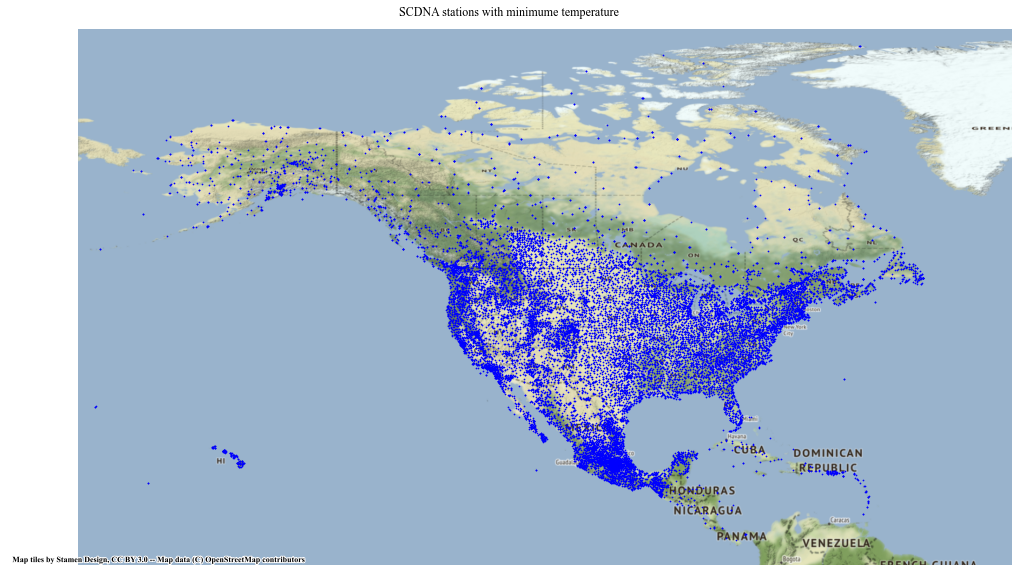

In [1]:
import xarray as xr
import pandas as pd
from   shapely.geometry import Point
import geopandas as gpd
import matplotlib
import os
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)


pwd = '/Users/shg096/Desktop/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'

infile_prcp  = pwd+'/prcp/SCDNA_v1.1.prcp.1979.nc'
outfile_prcp = pwd+'/prcp/SCDNA.prcp.gpkg'

infile_tmin  = pwd+'/tmin/SCDNA_v1.1.tmin.1979.nc'
outfile_tmin = pwd+'/tmin/SCDNA.tmin.gpkg'

infile_tmax  = pwd+'/tmax/SCDNA_v1.1.tmax.1979.nc'
outfile_tmax = pwd+'/tmax/SCDNA.tmax.gpkg'


def create_shp_SCDNA(infile, outfile):
    
    # load one the yearly nc files
    ds = xr.open_dataset(infile)
    
    nstn = ds.lat.shape[0] # number of stations

    points = pd.DataFrame()
    points['LATITUDE']  = ds.lat[:]
    points['LONGITUDE'] = ds.lon[:]
    points['ID']        = ds.stn[:]

    # the columns of the DataFrame
    points['geometry'] = points.apply(lambda row: Point(row.LONGITUDE, row.LATITUDE ), axis=1) # set the geometry
    points  = gpd.GeoDataFrame(points) # pass this to a geopandas dataframe
    points = points.set_crs("EPSG:4326") # set the projection to WGS 1984
    points.to_file(outfile)
    
create_shp_SCDNA(infile_prcp, outfile_prcp)
create_shp_SCDNA(infile_tmin, outfile_tmin)
create_shp_SCDNA(infile_tmax, outfile_tmax)



## visualizing the point shapefiles for precipitation stations
import contextily as ctx
import matplotlib.pyplot as plt

stations = gpd.read_file(outfile_tmin)

fig, ax = plt.subplots(figsize=(18, 10))
stations.plot(ax=ax, color='blue', markersize = 0.5)
ax.axis('off')
plt.axis('equal')
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
#ctx.add_basemap(ax, zoom=4, crs=crs)

plt.title ('SCDNA stations with minimume temperature')
plt.savefig('../fig/Example3_A.png')
plt.show()




/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_71739/3774115355.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile


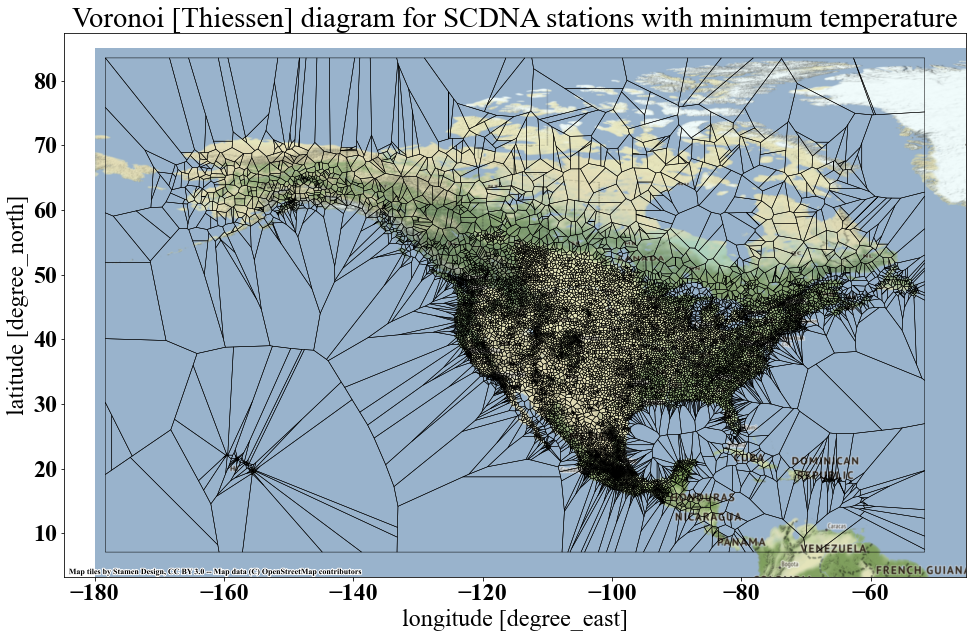

In [2]:
import shapefile
import geovoronoi
import os
from   shapely.geometry import Polygon
import numpy as np
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

infile_prcp  = pwd+'/prcp/SCDNA.prcp.gpkg'
outfile_prcp = pwd+'/prcp/SCDNA.prcp.voronoi.gpkg'

infile_tmin  = pwd+'/tmin/SCDNA.tmin.gpkg'
outfile_tmin = pwd+'/tmin/SCDNA.tmin.voronoi.gpkg'

infile_tmax  = pwd+'/tmax/SCDNA.tmax.gpkg'
outfile_tmax = pwd+'/tmax/SCDNA.tmax.voronoi.gpkg'


def voronoi_diagram(infile, outfile): # infile a point shapefile, outfile a shapefile
    
    # read the shapefile
    stations = gpd.read_file(infile)
    
    # get the total boundary of the shapefile
    stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile
    minx, miny, maxx, maxy = stations_buffert.total_bounds
    
    # create the bounding shapefile
    parts = []
    with shapefile.Writer('test.shp') as w:
        w.autoBalance = 1 # turn on function that keeps file stable if number of shapes and records don't line up
        w.field("ID_bounding",'N') # create (N)umerical attribute fields, integer

        # creating the polygon given the lat and lon
        parts.append([ (minx, miny),\
                       (minx, maxy), \
                       (maxx, maxy), \
                       (maxx, miny), \
                       (minx, miny)])

        # store polygon
        w.poly(parts)

        # update records/fields for the polygon
        w.record(1)

    boundary = gpd.read_file('test.shp')
    os.remove('test.dbf');os.remove('test.shx');os.remove('test.shp')
    
    # create the voroni diagram for given point shapefile
    coords = geovoronoi.points_to_coords(stations.geometry)

    poly_shapes, location = \
    geovoronoi.voronoi_regions_from_coords(coords, boundary.iloc[0].geometry)
    
    
    # pass te polygons to shapefile
    Thiessen = gpd.GeoDataFrame()
    Thiessen['geometry'] = None
    Thiessen['ID'] = None
    Thiessen['LATITUDE'] = None
    Thiessen['LONGITUDE'] = None


    for i in np.arange(len(poly_shapes)):
        Thiessen.loc[i, 'geometry'] = Polygon(poly_shapes[i])
        Thiessen.loc[i, 'ID']       = stations.iloc[location[i][0]].ID.astype(float)
        Thiessen.loc[i, 'LATITUDE'] = stations.iloc[location[i][0]].LATITUDE.astype(float)
        Thiessen.loc[i, 'LONGITUDE']= stations.iloc[location[i][0]].LONGITUDE.astype(float)
    
    Thiessen = Thiessen.set_crs("EPSG:4326")

    Thiessen.to_file(outfile)
    
voronoi_diagram(infile_prcp, outfile_prcp)
voronoi_diagram(infile_tmin, outfile_tmin)
voronoi_diagram(infile_tmax, outfile_tmax)

## visualization of voronoi diagram for precipitation stations
shp = gpd.read_file(outfile_tmin)
fig, ax = plt.subplots(figsize=(18, 10))
shp.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.5 , figsize=(15,30),ax=ax)
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
plt.title('Voronoi [Thiessen] diagram for SCDNA stations with minimum temperature')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_B.png')


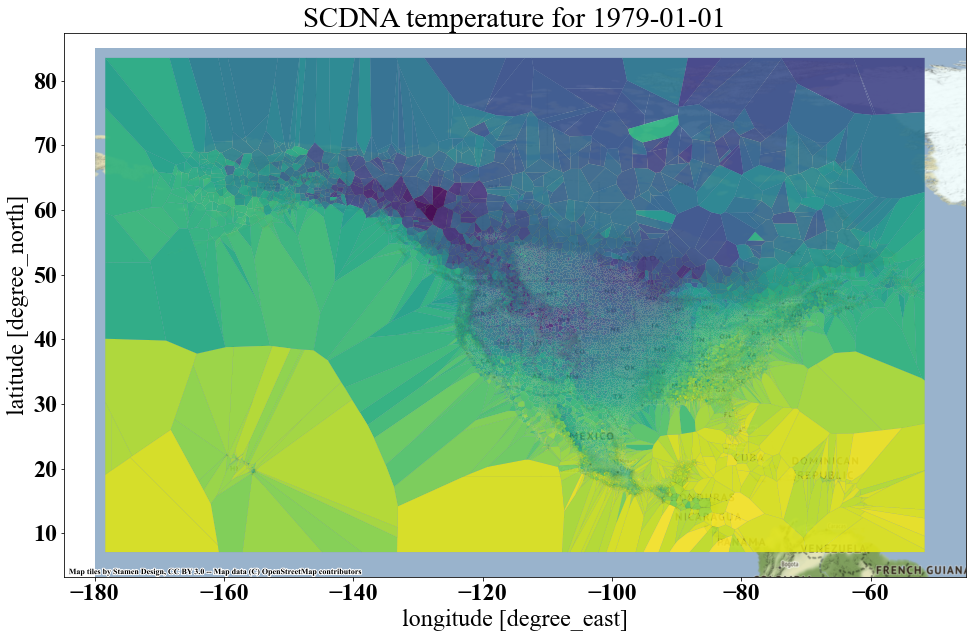

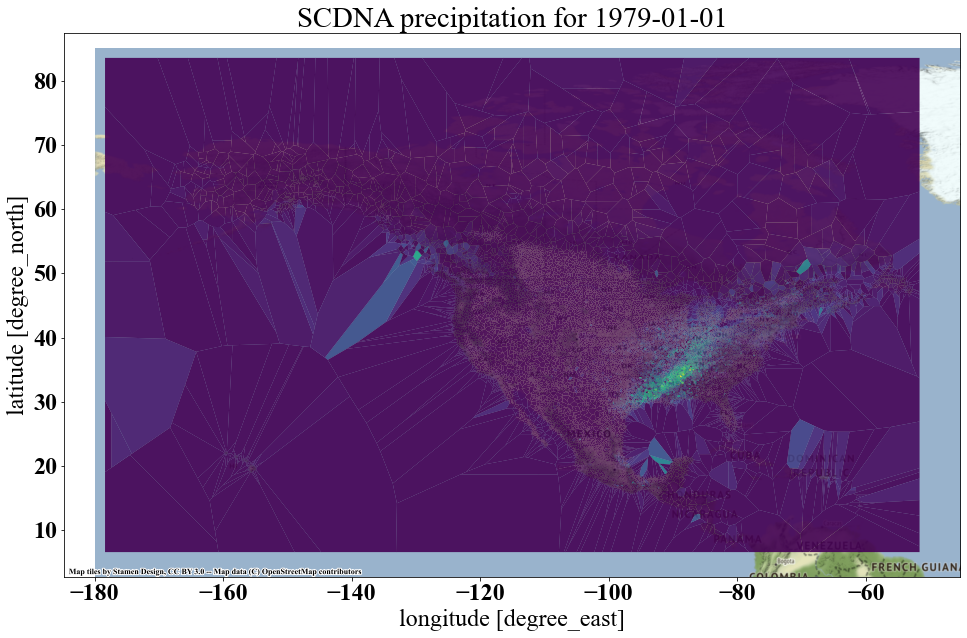

In [3]:
# visualize the voronoi diagram with data from SCDNA

voronoi_prcp = pwd+'/tmin/SCDNA.tmin.voronoi.gpkg'
infile_prcp  = pwd+'/tmin/SCDNA_v1.1.tmin.1979.nc'

#
Thiessen = gpd.read_file(voronoi_prcp)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
ds = xr.open_dataset(infile_prcp)
df = pd.DataFrame()
df ['values']     = ds.tmin.sel(time='1979-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)
df = df.sort_values(by='ID')# sort on values

# merge based on ID
Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.title('SCDNA temperature for 1979-01-01')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_C.png')



# visualize the voronoi diagram with data from SCDNA
voronoi_prcp = pwd+'/prcp/SCDNA.prcp.voronoi.gpkg'
infile_prcp  = pwd+'/prcp/SCDNA_v1.1.prcp.1979.nc'

#
Thiessen = gpd.read_file(voronoi_prcp)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
ds = xr.open_dataset(infile_prcp)
df = pd.DataFrame()
df ['values']     = ds.prcp.sel(time='1979-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)
df = df.sort_values(by='ID')# sort on values

# merge based on ID
Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.title('SCDNA precipitation for 1979-01-01')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_D.png')


In [4]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

# specifying EASYMORE needed arguments
esmr.case_name             = 'SCDNA_Medicine_Hat' # name of the case
esmr.temp_dir              = '../temporary/' # temporary path that the EASYMORE generated GIS files and rempped file will be saved
esmr.target_shp            = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp' # target shapefile that the source will be remmaped to
esmr.source_nc             = '/Users/shg096/Desktop/SCDNA/tmin/SCDNA_*.nc' # name of netCDF file(s) if multiple you can specify with *
esmr.var_names             = ['tmin'] # name of variables from source netCDF file(s) to be remapped
esmr.var_lon               = 'lon' # name of varibale longitude in source netCDF files 
esmr.var_lat               = 'lat' # name of variable latitude in source netCDF files
esmr.var_time              = 'time' # name of varibale time in source netCDF file
esmr.source_shp            = '/Users/shg096/Desktop/SCDNA/tmin/SCDNA.tmin.voronoi.gpkg'
esmr.source_shp_lat        =  'LATITUDE' # name_of_nc_files
esmr.source_shp_lon        =  'LONGITUDE'
esmr.output_dir            = '../output/' # location where the remapped netCDF file will be saved
esmr.format_list           =  ['f4'] # format of the varibales to be saved with
esmr.fill_value_list       = ['-9999.00'] # missing values for the varibales
#esmr.remap_csv             = '../temporary/SCDNA_Medicine_Hat_remapping.csv' # if uncommneted EASYMORE will use this and skip GIS taskes

# execute EASYMORE
esmr.nc_remapper()



EASYMORE version 0.0.2 is initiated.
no author name is provide and the author name is changed to (author name)!
EASYMORE will remap variable  tmin  from source file to variable  tmin  in remapped NeCDF file
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that no field for ID is provided in sink/target shapefile
arbitarary values of ID are added in the field ID_t
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in WGS84 projection;
for better appximation use the easymore equal area centroid function to preprocess target shapefile
EASYMORE detects that no field for latitude is provided in sink/target shapefile
latitude values are added in the field lat_t
EASYMORE detects that no field for longitude is provided in sink/target shapefile
longitude values are added in the field lon_t


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


it seems everything is OK with the sink/target shapefile; added to EASYMORE object target_shp_gpd
EASYMORE will save standard shapefile for EASYMORE claculation as:
../temporary/SCDNA_Medicine_Hat_target_shapefile.shp
EASYMORE detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
EASYMORE detects that all the varibales have dimensions of:
['stn', 'time']
EASYMORE detects that the longitude varibales has dimensions of:
['stn']
EASYMORE detects that the latitude varibales has dimensions of:
['stn']
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided
EASYMORE detects that no varibale for ID of the source netCDF file; an arbitatiry ID will be provided
EASYMORE detects that source shapefile is in WGS84 (epsg:4326)
The latitude and longitude in source NetCDF files are not unique
EASYMORE is creating the shapefile from the netCDF file and saving it here:
../temporary/SCDNA_Medicine_Hat_source_shapefile.shp

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site

------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1979.nc to ../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc
Started at date and time 2021-08-29 11:00:12.706179
Ended   at date and time 2021-08-29 11:00:14.916699
------
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1980.nc to ../output/SCDNA_Medicine_Hat_remapped_1980-01-01-00-00-00.nc
Started at date and time 2021-08-29 11:00:14.956784
Ended   at date and time 2021-08-29 11:00:17.020299
------
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1981.nc to ../output/SCDNA_Medicine_Hat_remapped_1981-01-01-00-00-00.nc
Started at date and time 2021-08-29 11:00:17.061588
Ended   at date and time 2021-08-29 11:00:19.076515
------


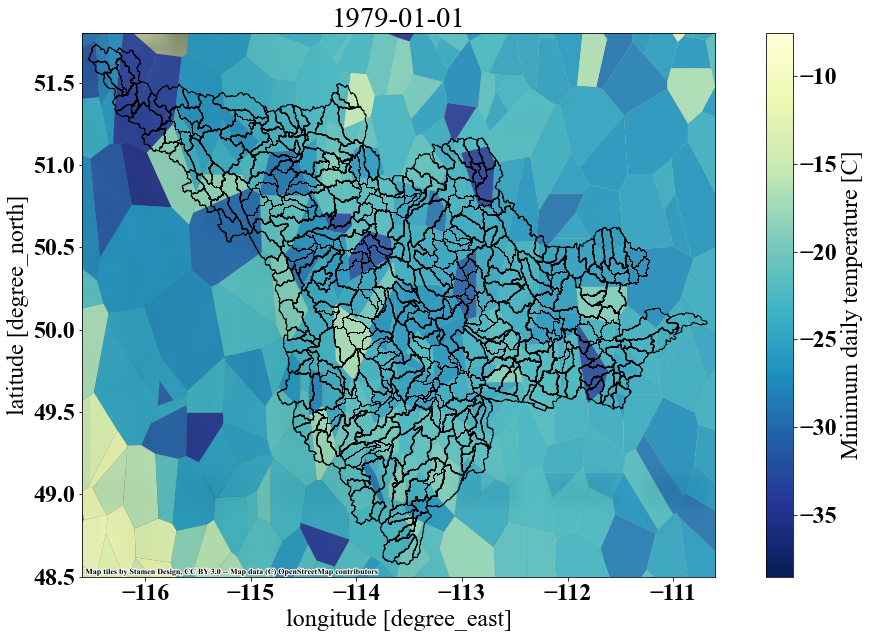

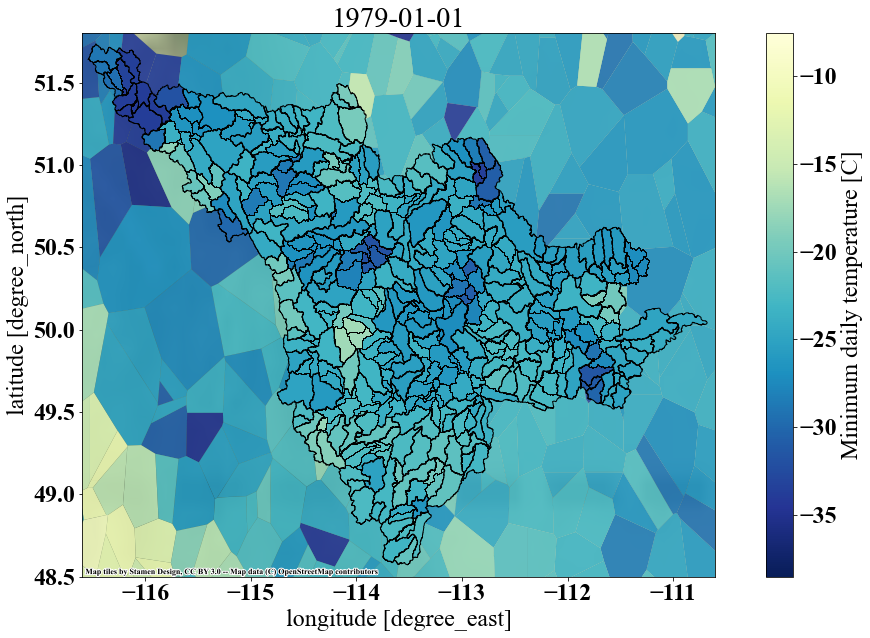

In [5]:
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors

import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1979.nc')
Thiessen = gpd.read_file('/Users/shg096/Desktop/SCDNA/tmin/SCDNA.tmin.voronoi.gpkg')
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')
shp_target = gpd.read_file(esmr.temp_dir+ esmr.case_name +\
                           '_target_shapefile.shp') # load the target shapefile
shp_target = shp_target.sort_values(by='ID_t')


#
df = pd.DataFrame()
df ['value']     = ds.tmin.sel(time='1979-01-10')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)


df = df.dropna() # drop the values that are NaN
df = df.sort_values(by='ID')# sort on values

Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

# subsetting
Thiessen = Thiessen[Thiessen['lat_nc']<52]
Thiessen = Thiessen[Thiessen['lat_nc']>48]
Thiessen = Thiessen[Thiessen['lon_nc']<-110]
Thiessen = Thiessen[Thiessen['lon_nc']>-120]

Thiessen = gpd.GeoDataFrame(Thiessen)

## visualization
norm = colors.Normalize(vmin=Thiessen.value.min(), vmax=Thiessen.value.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu_r')

fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='value', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, cmap='YlGnBu_r', legend=False)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title('1979-01-01')
shp_target.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax)

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Minimum daily temperature [C]')
plt.savefig('../fig/Example3_E.png')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='value', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, cmap='YlGnBu_r')
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title('1979-01-01')


ds2 = xr.open_dataset('../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc')

shp_target ['value'] = ds2.tmin.sel(time='1979-01-10')

shp_target.plot(column='value', edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax,\
                legend=False, cmap='YlGnBu_r',\
                vmin = Thiessen.value.min(), vmax = Thiessen.value.max())

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Minimum daily temperature [C]')
plt.savefig('../fig/Example3_F.png')
